In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
pd.options.display.max_columns=999
df = pd.read_csv('Untitled spreadsheet - Sheet1.csv').dropna()
#df = df.drop('Unnamed: 3', 1)
df = df.dropna()
borders = []
for i in df['Borders']:
    borders.append(i.split('/'))
within = []
for i in df['Within']:
    within.append(i.split('/'))
df['Borders'] = borders
df['Within'] = within
df2 = df.drop(0)
borders = []
for n in df.index:
    x = df.loc[n]['Name of country']
    for i in df.loc[n]['Borders']:
        borders.append([x,i])
borders = pd.DataFrame(borders)
borders = borders.drop([0,1]).reset_index().drop('index',1)
# quality of life indicators
cpi = pd.read_csv('cpi.csv')
cpi = cpi[['Country','2015 cpi']]
cpi = cpi.replace('-',np.nan)
cpi['2015 cpi'] = [float(x) for x in cpi['2015 cpi']]
edbi = pd.read_csv('edbiscores.csv')
homicide = pd.read_csv('homicide.csv')
pfi = pd.read_csv('pfi.csv')[['Country','Score']]
pfi.columns = ['Country','2018 pfi']
pfi['2018 pfi'] = [float(x) for x in pfi['2018 pfi']]
homicide.columns = ['Country','Region','Subregion','Homicide Rate','Homicide County','Year','Source']
qol = pd.merge(cpi,pfi,on='Country')
qol = pd.merge(qol,edbi,on='Country')
qol = pd.merge(qol, homicide, on='Country')
qol['score'] = qol['2015 cpi'] / qol['2018 pfi'] * qol['DB 2019']
qol.head()
#GDP and Population
data = pd.read_csv('world_indicators_all_years.csv')
data = data[data['Time'] == '2016']
data = data.replace('Iran, Islamic Rep.','Iran').replace('Korea, Dem. People’s Rep.',"Democratic People's Republic of Korea").replace('Lao PDR','Laos').replace('Korea, Rep.','Korea,South').replace('Macedonia, FYR','Macedonia').replace('Myanmar','Myanmar (Burma)').replace('Russian Federation','Russia').replace('Slovak Republic','Slovakia').replace('Syrian Arab Republic','Syria').replace('Venezuela, RB','Venezuela').replace('Yemen, Rep.','Yemen')
data1 = data[['Country Name', 'Population, total [SP.POP.TOTL]','Population growth (annual %) [SP.POP.GROW]','GDP (current US$) [NY.GDP.MKTP.CD]', 'GDP per capita (current US$) [NY.GDP.PCAP.CD]']]
data1 = data1.replace('..',np.nan)
for x in [*data1.columns][1:]:
    data1[x] = [float(i) for i in data1[x]]
data1['Population, total [SP.POP.TOTL]'] = [float(n) for n in data1['Population, total [SP.POP.TOTL]']]
data1 = pd.merge(qol,data1,left_on='Country',right_on='Country Name')
#treaties
schengen = ['Austria','Belgium','Czech Republic','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Iceland','Italy','Latvia','Liechtenstein','Lithuania','Luxembourg','Malta','Netherlands','Monaco','Norway','Poland','Portugal','San Marino','Slovakia','Slovenia','Spain','Sweden','Switzerland','Vatican City']
common = ['Ireland','United Kingdom']
unionstate = ['Russia','Belarus']
peaceandfriendship = ['India','Bhutan','Nepal']
ca4 = ['El Salvador','Honduras','Guatemala','Nicaragua']
tasman = ['Australia','New Zealand']
andean = ['Bolivia','Ecuador','Colombia','Peru']
caricom = ['Antigua and Barbuda','Barbados', 'Belize', 'Dominica', 'Grenada','Guyana','Jamaica','Saint Kitts and Nevis','Saint Lucia','Saint Vincent and the Grenadines','Suriname','Trinidad and Tobago']
gcc = ['Saudi Arabia','Oman','Kuwait','United Arab Emirates','Bahrain']
eac = ['Kenya','Tanzania','Uganda','South Sudan','Rwanda','Burundi']
table = [schengen+common+unionstate+peaceandfriendship+ca4+tasman+andean+caricom+gcc+eac,['Schengen'] * len(schengen) + ['Common'] * len(common) + ['Union State'] * len(unionstate) + ['Peace and Friendship'] * len(peaceandfriendship) + ['Central America 4'] * len(ca4) + ['Trans-Tasman Agreement'] * len(tasman) + ['Andean Community'] * len(andean) + len(caricom) * ['Caricom'] + len(gcc) * ['Gulf Cooperation Council'] + ['East African Community'] * len(eac)]
treaties = pd.DataFrame(table).transpose()
treaties.columns = ['Country','Treaty']
notreaty = pd.DataFrame([*set(treaties['Country'])^set(data1['Country Name'])])
notreaty['Treaty'] = None
notreaty.columns = ['Country','Treaty']
treaties = pd.concat([notreaty,treaties])
data1 = pd.merge(data1,treaties)
#bring it all together
test1 = pd.merge(borders,data1,left_on=0,right_on='Country Name')
test1.columns = ['Country 1','Country 2','C','2015 cpi', '2018 pfi', 'DB 2018',
       'DB 2019', 'Region', 'Subregion', 'Homicide Rate', 'Homicide County',
       'Year', 'Source', 'score', 'Country Name','Population 1','Population growth 1','GDP 1','GDP per capita 1','Treaty 1']
test1['Country 2'] = [s.rstrip(" ").lstrip(' ') for s in test1['Country 2']]
test2 = pd.merge(test1,data1,left_on='Country 2',right_on='Country Name')
#More statistics
test2.columns = ['Country 1', 'Country 2', 'C', '2015 cpi_x', '2018 pfi_x', 'DB 2018_x', 'DB 2019_x', 'Region_x', 'Subregion_x',
       'Homicide Rate_x', 'Homicide County_x', 'Year_x', 'Source_x', 'score_x',
       'Country Name_x', 'Population 1', 'Population growth 1', 'GDP 1',
       'GDP per capita 1','Treaty 1', 'Country', '2015 cpi_y', '2018 pfi_y', 'DB 2018_y', 'DB 2019_y', 'Region_y', 'Subregion_y',
       'Homicide Rate_y', 'Homicide County_y', 'Year_y', 'Source_y', 'score_y',
       'Country Name_y', 'Population 2',
       'Population growth 2','GDP 2','GDP per capita 2','Treaty 2']
test2['Population difference'] = test2['Population 1'] / test2['Population 2']
test2['Population growth difference'] = test2['Population growth 1']/ test2['Population growth 2']
test2['GDP difference'] = test2['GDP 1'] / test2['GDP 2']
test2['GDP per capita difference'] = test2['GDP per capita 1'] / test2['GDP per capita 2']
df1 = test2
test2['Population difference'] = [1/x if x > 1 else x for x in test2['Population difference'] ]
test2['Population growth difference'] = [1/x if x > 1 else x for x in test2['Population growth difference']]
test2['GDP difference'] = [1/x if x > 1 else x for x in test2['GDP difference']]
test2['GDP per capita difference'] = [1/x if x > 1 else x for x in test2['GDP per capita difference']]
test2 = pd.merge(test2,df2, left_on='Country 1', right_on='Name of country').drop('Borders',1)
test2['GDP product'] = test2['GDP 1'] *test2['GDP 2']
test2['GDP per capita in both'] = (test2['GDP 1'] + test2['GDP 2']) / (test2['Population 1'] + test2['Population 2'])
test2 = test2.drop_duplicates('GDP product').reset_index()
df1['cpi difference'] = df1['2015 cpi_x'] / df1['2015 cpi_y']
#df1['cpi difference'] = [1/x if x > 1 for x in df1['cpi difference'] else x]
df1['cpi difference'] = [1/x if x > 1 else x for x in df1['cpi difference']]
df1['db difference'] = df1['DB 2019_x'] / df1['DB 2019_y']
df1['db difference'] = [1/x if x > 1 else x for x in df1['db difference']]
df1['pfi difference'] = df1['2018 pfi_x'] / df1['2018 pfi_y']
df1['pfi difference'] = [1/x if x > 1 else x for x in df1['pfi difference']]
df1['homicide difference'] = df1['Homicide Rate_x'] / df1['Homicide Rate_y']
df1['homicide difference'] = [1/x if x > 1 else x for x in df1['homicide difference']]
df1['Country Similarity'] = (df1['cpi difference']+df1['db difference']+df1['pfi difference']+df1['homicide difference']) /4
df1['average cpi'] = df1[['2015 cpi_x','2015 cpi_y']].mean(axis=1)
df1['average db'] = df1[['DB 2019_x','DB 2019_y']].mean(axis=1)
df1['average pfi'] = df1[['2018 pfi_x','2018 pfi_y']].mean(axis=1)
df1['average homicide'] = df1[['Homicide Rate_x','Homicide Rate_y']].mean(axis=1)
df1['Border Status'] = np.where(df1['Treaty 1'] == df1['Treaty 2'], 'Open', 'Closed')
df1['Combined Population'] = df1['Population 1'] + df1['Population 2']
df1['viability'] = df1['average cpi'] * df1['average db'] / (df1['average pfi'] * df1['average homicide'])
df1 = df1.drop_duplicates('Combined Population').sort_values('viability', ascending = False).reset_index().drop('index',1)
df1.head()

Country 1     Country 2        C  2015 cpi_x  2018 pfi_x  DB 2018_x  \
0   Algeria       Tunisia  Algeria        36.0       43.13      47.59   
1     Benin  Burkina Faso    Benin        37.0       30.16      51.29   
2   Algeria         Niger  Algeria        36.0       43.13      47.59   
3     Benin         Niger    Benin        37.0       30.16      51.29   
4   Algeria    Mauritania  Algeria        36.0       43.13      47.59   

   DB 2019_x Region_x      Subregion_x  Homicide Rate_x  Homicide County_x  \
0      49.65   Africa  Northern Africa             1.36              542.0   
1      51.42   Africa   Western Africa             6.18              654.0   
2      49.65   Africa  Northern Africa             1.36              542.0   
3      51.42   Africa   Western Africa             6.18              654.0   
4      49.65   Africa  Northern Africa             1.36              542.0   

   Year_x      Source_x    score_x Country Name_x  Population 1  \
0  2015.0           CTS  41.442152        Algeria    40606052.0   
1  2015.0  WHO Estimate  63.081565          Benin    10872298.0   
2  2015.0           CTS  41.442152        Algeria    40606052.0   
3  2015.0  WHO Estimate  63.081565          Benin    10872298.0   
4  2015.0           CTS  41.442152        Algeria    40606052.0   

   Population growth 1         GDP 1  GDP per capita 1 Treaty 1       Country  \
0             1.825463  1.590491e+11       3916.881571     None       Tunisia   
1             2.763534  8.583031e+09        789.440411     None  Burkina Faso   
2             1.825463  1.590491e+11       3916.881571     None         Niger   
3             2.763534  8.583031e+09        789.440411     None         Niger   
4             1.825463  1.590491e+11       3916.881571     None    Mauritania   

   2015 cpi_y  2018 pfi_y  DB 2018_y  DB 2019_y Region_y      Subregion_y  \
0        38.0       30.91      64.60      66.11   Africa  Northern Africa   
1        38.0       23.33      51.45      51.57   Africa   Western Africa   
2        34.0       27.40      52.48      53.72   Africa   Western Africa   
3        34.0       27.40      52.48      53.72   Africa   Western Africa   
4        31.0       29.09      51.07      51.99   Africa   Western Africa   

   Homicide Rate_y  Homicide County_y  Year_y      Source_y    score_y  \
0             3.05              332.0  2012.0           WHO  81.274021   
1             0.37               67.0  2015.0           NSO  83.997428   
2             4.44              788.0  2012.0           WHO  66.659854   
3             4.44              788.0  2012.0           WHO  66.659854   
4             9.94              416.0  2015.0  WHO Estimate  55.403575   

  Country Name_y  Population 2  Population growth 2         GDP 2  \
0        Tunisia    11403248.0             1.142911  4.206255e+10   
1   Burkina Faso    18646433.0             2.915614  1.169324e+10   
2          Niger    20672987.0             3.826066  7.528388e+09   
3          Niger    20672987.0             3.826066  7.528388e+09   
4     Mauritania     4301018.0             2.798060  4.739299e+09   

   GDP per capita 2 Treaty 2  Population difference  \
0       3688.646375     None               0.280826   
1        627.103079     None               0.583077   
2        364.165462     None               0.509111   
3        364.165462     None               0.525918   
4       1101.901627     None               0.105921   

   Population growth difference  GDP difference  GDP per capita difference  \
0                      0.626093        0.264463                   0.941730   
1                      0.947840        0.734017                   0.794364   
2                      0.477112        0.047334                   0.092973   
3                      0.722291        0.877125                   0.461296   
4                      0.652403        0.029798                   0.281321   

   cpi difference  db difference  pfi difference  homicide difference  \
0       

In [3]:
df1[df1['2015 cpi_x'] > 70][df1['2015 cpi_y'] > 70][df1['Border Status'] == 'Closed']

/home/matthew/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Country 1      Country 2       C  2015 cpi_x  2018 pfi_x  DB 2018_x  \
34    Canada  United States  Canada        83.0       15.28      78.88   

    DB 2019_x  Region_x       Subregion_x  Homicide Rate_x  Homicide County_x  \
34      79.26  Americas  Northern America             1.68              611.0   

    Year_x     Source_x    score_x Country Name_x  Population 1  \
34  2016.0  OAS/CTS/SDG  430.53534         Canada    36286425.0   

    Population growth 1         GDP 1  GDP per capita 1 Treaty 1  \
34             1.213891  1.529760e+12      42157.927991     None   

          Country  2015 cpi_y  2018 pfi_y  DB 2018_y  DB 2019_y  Region_y  \
34  United States        76.0       23.73      82.76      82.75  Americas   

         Subregion_y  Homicide Rate_y  Homicide County_y  Year_y  \
34  Northern America             5.35            17250.0  2016.0   

        Source_y     score_y Country Name_y  Population 2  \
34  NP/UNSDC/CTS  265.023177  United States   323127513.0   

    Population growth 2         GDP 2  GDP per capita 2 Treaty 2  \
34             0.692801  1.862448e+13      57638.159088     None   

    Population difference  Population growth difference  GDP difference  \
34               0.112298                      0.570728        0.082137   

    GDP per capita difference  cpi difference  db difference  pfi difference  \
34                   0.731424        0.915663       0.957825        0.643911   

    homicide difference  Country Similarity  average cpi  average db  \
34             0.314019            0.707854         79.5      81.005   

    average pfi  average homicide Border Status  Combined Population  \
34       19.505             3.515        Closed          359413938.0   

    viability  
34  93.930724

In [4]:
df1[df1['2018 pfi_x'] < 30][df1['2018 pfi_y'] < 30][df1['Border Status'] == 'Closed'].sort_values('Combined Population',ascending=False)

/home/matthew/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Country 1      Country 2             C  2015 cpi_x  2018 pfi_x  \
34         Canada  United States        Canada        83.0       15.28   
69      Argentina          Chile     Argentina        32.0       26.05   
155  South Africa        Namibia  South Africa        44.0       20.39   
153      Botswana   South Africa      Botswana        63.0       25.29   
183       Lesotho   South Africa       Lesotho        44.0       28.78   
81      Argentina        Uruguay     Argentina        32.0       26.05   
32          Ghana   Burkina Faso         Ghana        47.0       18.41   
66   Burkina Faso          Niger  Burkina Faso        38.0       23.33   
42        Romania        Hungary       Romania        46.0       23.65   
38        Romania         Serbia       Romania        46.0       23.65   
128       Senegal     Mauritania       Senegal        44.0       25.61   
48        Hungary         Serbia       Hungary        51.0       29.11   
41        Croatia        Hungary       Croatia        51.0       28.94   
52        Albania         Greece       Albania        36.0       29.49   
36        Croatia         Serbia       Croatia        51.0       28.94   
56        Albania         Serbia       Albania        36.0       29.49   
49        Armenia        Georgia       Armenia        35.0       29.99   
26        Croatia       Slovenia       Croatia        51.0       28.94   
121      Botswana        Namibia      Botswana        63.0       25.29   

     DB 2018_x  DB 2019_x  Region_x       Subregion_x  Homicide Rate_x  \
34       78.88      79.26  Americas  Northern America             1.68   
69       57.93      58.80  Americas     South America             5.94   
155      64.66      66.03    Africa   Southern Africa            33.97   
153      64.94      65.40    Africa   Southern Africa            15.04   
183      60.41      60.60    Africa   Southern Africa            41.25   
81       57.93      58.80  Americas     South America             5.94   
32       57.16      59.22    Africa    Western Africa             1.68   
66       51.45      51.57    Africa    Western Africa             0.37   
42       72.83      72.30    Europe    Eastern Europe             1.25   
38       72.83      72.30    Europe    Eastern Europe             1.25   
128      53.78      54.15    Africa    Western Africa             7.38   
48       71.94      72.28    Europe    Eastern Europe             2.07   
41       71.06      71.40    Europe   Southern Europe             1.04   
52       69.01      69.51    Europe   Southern Europe             2.70   
36       71.06      71.40    Europe   Southern Europe             1.04   
56       69.01      69.51    Europe   Southern Europe             2.70   
49       73.31      75.37      Asia      Western Asia             2.98   
26       71.06      71.40    Europe   Southern Europe             1.04   
121      64.94      65.40    Africa   Southern Africa            15.04   

     Homicide County_x  Year_x       Source_x     score_x Country Name_x  \
34               611.0  2016.0    OAS/CTS/SDG  430.535340         Canada   
69              2605.0  2016.0            CTS   72.230326      Argentina   
155            19016.0  2016.0             NP  142.487494   South Africa   
153              303.0  2010.0            WHO  162.918149       Botswana   
183              897.0  2015.0        CTS/NSO   92.647672        Lesotho   
81              2605.0  2016.0            CTS   72.230326      Argentina   
32               423.0  2011.0            WHO  151.186312          Ghana   
66                67.0  2015.0            NSO   83.997428   Burkina Faso   
42               247.0  2016.0  SDG/UNSDC/CTS  140.625793        Romania   
38               247.0  2016.0  SDG/UNSDC/CTS  140.625793        Romania   
128             1105.0  2015.0   WHO Estimate   93.033971        Senegal   
48               202.0  2016.0      UNSDC/CTS  126.632772        Hungary   
41                44.0  2016.0        MOI/CTS  125.825847 

In [5]:
df1[df1['DB 2018_x'] > 70][df1['DB 2018_y'] > 70][df1['Border Status'] == 'Closed'].sort_values('Combined Population',ascending=False)

/home/matthew/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Country 1      Country 2              C  2015 cpi_x  2018 pfi_x  \
122  United States         Mexico  United States        76.0       23.73   
34          Canada  United States         Canada        83.0       15.28   
71        Malaysia       Thailand       Malaysia        50.0       47.41   
58         Belarus         Poland        Belarus        32.0       52.59   
35       Singapore       Malaysia      Singapore        85.0       50.95   
42         Romania        Hungary        Romania        46.0       23.65   
39        Bulgaria        Romania       Bulgaria        41.0       35.22   
38         Romania         Serbia        Romania        46.0       23.65   
54         Moldova        Romania        Moldova        33.0       30.01   
48         Hungary         Serbia        Hungary        51.0       29.11   
45        Bulgaria         Serbia       Bulgaria        41.0       35.22   
41         Croatia        Hungary        Croatia        51.0       28.94   
55         Georgia     Azerbaijan        Georgia        52.0       27.34   
86         Armenia     Azerbaijan        Armenia        35.0       29.99   
83         Belarus      Lithuania        Belarus        32.0       52.59   
73         Belarus         Latvia        Belarus        32.0       52.59   
36         Croatia         Serbia        Croatia        51.0       28.94   
63          Serbia     Montenegro         Serbia        40.0       29.58   
49         Armenia        Georgia        Armenia        35.0       29.99   
26         Croatia       Slovenia        Croatia        51.0       28.94   
59         Croatia     Montenegro        Croatia        51.0       28.94   

     DB 2018_x  DB 2019_x  Region_x         Subregion_x  Homicide Rate_x  \
122      82.76      82.75  Americas    Northern America             5.35   
34       78.88      79.26  Americas    Northern America             1.68   
71       78.03      80.60      Asia  South-Eastern Asia             2.11   
58       75.05      75.77    Europe      Eastern Europe             3.58   
35       84.97      85.24      Asia  South-Eastern Asia             0.32   
42       72.83      72.30    Europe      Eastern Europe             1.25   
39       71.13      71.24    Europe      Eastern Europe             1.14   
38       72.83      72.30    Europe      Eastern Europe             1.25   
54       73.16      73.54    Europe      Eastern Europe             3.19   
48       71.94      72.28    Europe      Eastern Europe             2.07   
45       71.13      71.24    Europe      Eastern Europe             1.14   
41       71.06      71.40    Europe     Southern Europe             1.04   
55       82.80      83.28      Asia        Western Asia             0.99   
86       73.31      75.37      Asia        Western Asia             2.98   
83       75.05      75.77    Europe      Eastern Europe             3.58   
73       75.05      75.77    Europe      Eastern Europe             3.58   
36       71.06      71.40    Europe     Southern Europe             1.04   
63       73.32      73.49    Europe     Southern Europe             1.39   
49       73.31      75.37      Asia        Western Asia             2.98   
26       71.06      71.40    Europe     Southern Europe             1.04   
59       71.06      71.40    Europe     Southern Europe             1.04   

     Homicide County_x  Year_x          Source_x     score_x Country Name_x  \
122            17250.0  2016.0      NP/UNSDC/CTS  265.023177  United States   
34               611.0  2016.0       OAS/CTS/SDG  430.535340         Canada   
71               627.0  2013.0      UNSDC/WHO/NP   85.003164       Malaysia   
58               340.0  2014.0         UNSDC/CTS   46.104583        Belarus   
35                18.0  2016.0      UNSDC/NP/CTS  142.206084      Singapore   
42               247.0  2016.0     SDG/UNSDC/CTS  140.625793        Romania   
39                81.0  2016.0     UNSDC/EUR/CTS   82.931289       Bulgaria   
38               247.0  2016.0 

In [6]:
df1[df1['Homicide Rate_x'] < 2][df1['Homicide Rate_y'] < 2][df1['Border Status'] == 'Closed'].sort_values('Combined Population',ascending=False)

/home/matthew/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Country 1     Country 2             C  2015 cpi_x  2018 pfi_x  \
68       Vietnam         China       Vietnam        31.0       75.05   
70    Tajikistan         China    Tajikistan        26.0       50.06   
43        Bhutan         China        Bhutan        65.0       30.73   
95      Cambodia       Vietnam      Cambodia        21.0       45.90   
32         Ghana  Burkina Faso         Ghana        47.0       18.41   
60  Saudi Arabia        Jordan  Saudi Arabia        52.0       63.13   
40         Qatar  Saudi Arabia         Qatar        71.0       40.16   
39      Bulgaria       Romania      Bulgaria        41.0       35.22   
38       Romania        Serbia       Romania        46.0       23.65   
44        Israel        Jordan        Israel        61.0       30.26   
33      Bulgaria        Greece      Bulgaria        41.0       35.22   
45      Bulgaria        Serbia      Bulgaria        41.0       35.22   
36       Croatia        Serbia       Croatia        51.0       28.94   
26       Croatia      Slovenia       Croatia        51.0       28.94   

    DB 2018_x  DB 2019_x Region_x         Subregion_x  Homicide Rate_x  \
68      66.77      68.36     Asia  South-Eastern Asia             1.52   
70      57.03      57.11     Asia        Central Asia             1.61   
43      65.88      66.08     Asia       Southern Asia             1.13   
95      54.39      54.80     Asia  South-Eastern Asia             1.84   
32      57.16      59.22   Africa      Western Africa             1.68   
60      61.88      63.50     Asia        Western Asia             1.50   
40      65.25      65.89     Asia        Western Asia             0.38   
39      71.13      71.24   Europe      Eastern Europe             1.14   
38      72.83      72.30   Europe      Eastern Europe             1.25   
44      72.59      73.23     Asia        Western Asia             1.36   
33      71.13      71.24   Europe      Eastern Europe             1.14   
45      71.13      71.24   Europe      Eastern Europe             1.14   
36      71.06      71.40   Europe     Southern Europe             1.04   
26      71.06      71.40   Europe     Southern Europe             1.04   

    Homicide County_x  Year_x       Source_x     score_x Country Name_x  \
68             1358.0  2011.0            WHO   28.236642        Vietnam   
70              126.0  2011.0     TSMNEE/CTS   29.661606     Tajikistan   
43                9.0  2016.0        NSO/CTS  139.772210         Bhutan   
95              268.0  2011.0         JP/WHO   25.071895       Cambodia   
32              423.0  2011.0            WHO  151.186312          Ghana   
60              472.0  2015.0        NSO/CTS   52.304768   Saudi Arabia   
40                9.0  2014.0       UNSDC/MD  116.488795          Qatar   
39               81.0  2016.0  UNSDC/EUR/CTS   82.931289       Bulgaria   
38              247.0  2016.0  SDG/UNSDC/CTS  140.625793        Romania   
44              110.0  2015.0    NSO/CTS/SDG  147.621613         Israel   
33               81.0  2016.0  UNSDC/EUR/CTS   82.931289       Bulgaria   
45               81.0  2016.0  UNSDC/EUR/CTS   82.931289       Bulgaria   
36               44.0  2016.0        MOI/CTS  125.825847        Croatia   
26               44.0  2016.0        MOI/CTS  125.825847        Croatia   

    Population 1  Population growth 1         GDP 1  GDP per capita 1  \
68    92701100.0             1.071293  2.052762e+11       2214.387662   
70     8734951.0             2.155884  6.951657e+09        795.843864   
43      797765.0             1.309547  2.212639e+09       2773.547135   
95    15762370.0             1.564833  2.001675e+10       1269.907238   
32    28206728.0             2.236738  4.268978e+10       1513.461034   
60    32275687.0             2.251422  6.464384e+11      20028.648207   
40     2569804.0             3.495070  1.524519e+11      59324.338773   
39     7127822.0            -0.701382  5.323788e+10       7469.025247   
38    19705301.0            -0.5

In [7]:
df1[df1['2015 cpi_x'] > 50][df1['2015 cpi_y'] > 50][df1['Border Status'] == 'Closed'].sort_values('Combined Population',ascending=False)

/home/matthew/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Country 1      Country 2             C  2015 cpi_x  2018 pfi_x  \
34         Canada  United States        Canada        83.0       15.28   
60   Saudi Arabia         Jordan  Saudi Arabia        52.0       63.13   
40          Qatar   Saudi Arabia         Qatar        71.0       40.16   
44         Israel         Jordan        Israel        61.0       30.26   
41        Croatia        Hungary       Croatia        51.0       28.94   
26        Croatia       Slovenia       Croatia        51.0       28.94   
121      Botswana        Namibia      Botswana        63.0       25.29   

     DB 2018_x  DB 2019_x  Region_x       Subregion_x  Homicide Rate_x  \
34       78.88      79.26  Americas  Northern America             1.68   
60       61.88      63.50      Asia      Western Asia             1.50   
40       65.25      65.89      Asia      Western Asia             0.38   
44       72.59      73.23      Asia      Western Asia             1.36   
41       71.06      71.40    Europe   Southern Europe             1.04   
26       71.06      71.40    Europe   Southern Europe             1.04   
121      64.94      65.40    Africa   Southern Africa            15.04   

     Homicide County_x  Year_x     Source_x     score_x Country Name_x  \
34               611.0  2016.0  OAS/CTS/SDG  430.535340         Canada   
60               472.0  2015.0      NSO/CTS   52.304768   Saudi Arabia   
40                 9.0  2014.0     UNSDC/MD  116.488795          Qatar   
44               110.0  2015.0  NSO/CTS/SDG  147.621613         Israel   
41                44.0  2016.0      MOI/CTS  125.825847        Croatia   
26                44.0  2016.0      MOI/CTS  125.825847        Croatia   
121              303.0  2010.0          WHO  162.918149       Botswana   

     Population 1  Population growth 1         GDP 1  GDP per capita 1  \
34     36286425.0             1.213891  1.529760e+12      42157.927991   
60     32275687.0             2.251422  6.464384e+11      20028.648207   
40      2569804.0             3.495070  1.524519e+11      59324.338773   
44      8547100.0             1.973220  3.177448e+11      37175.742029   
41      4170600.0            -0.788234  5.071496e+10      12160.110629   
26      4170600.0            -0.788234  5.071496e+10      12160.110629   
121     2250260.0             1.841666  1.558114e+10       6924.149775   

                     Treaty 1        Country  2015 cpi_y  2018 pfi_y  \
34                       None  United States        76.0       23.73   
60   Gulf Cooperation Council         Jordan        53.0       41.71   
40                       None   Saudi Arabia        52.0       63.13   
44                       None         Jordan        53.0       41.71   
41                       None        Hungary        51.0       29.11   
26                       None       Slovenia        60.0       21.69   
121                      None        Namibia        53.0       20.24   

     DB 2018_y  DB 2019_y  Region_y       Subregion_y  Homicide Rate_y  \
34       82.76      82.75  Americas  Northern America             5.35   
60       59.56      60.98      Asia      Western Asia             1.55   
40       61.88      63.50      Asia      Western Asia             1.50   
44       59.56      60.98      Asia      Western Asia             1.55   
41       71.94      72.28    Europe    Eastern Europe             2.07   
26       75.59      75.61    Europe   Southern Europe             0.48   
121      60.29      60.53    Africa   Southern Africa            17.14   

     Homicide County_y  Year_y       Source_y     score_y Country Name_y  \
34             17250.0  2016.0   NP/UNSDC/CTS  265.023177  United States   
60               145.0  2016.0     CTS/SDG/NP   77.485975         Jordan   
40               472.0  2015.0        NSO/CTS   52.304768   Saudi Arabia   
44               145.0  2016.0     CTS/SDG/NP   77.485975         Jordan   
41               202.0  2016.0      UNSDC/CTS  126.632772        Hungary   
26        

In [8]:
df1[df1['Border Status']=='Closed'].shape

(152, 54)

In [9]:
df1[df1['Border Status']=='Open'].shape

(56, 54)

In [10]:
112/312

0.358974358974359

In [11]:
a = sum([x for x in [*df1[df1['Border Status']=='Closed']['Population 1']] + [*df1[df1['Border Status']=='Closed']['Population 2']] if str(x) != 'nan'])
b = sum([x for x in [*df1[df1['Border Status']=='Open']['Population 1']] + [*df1[df1['Border Status']=='Open']['Population 2']] if str(x) != 'nan'])
a/b

4.724795523817522

In [12]:
data1.sort_values('Homicide Rate')

Country  2015 cpi  2018 pfi  DB 2018  DB 2019    Region  \
65          Japan      75.0     28.64    75.60    75.65      Asia   
57        Iceland      79.0     14.10    79.30    79.35    Europe   
117     Singapore      85.0     50.95    84.97    85.24      Asia   
20   Burkina Faso      38.0     23.33    51.45    51.57    Africa   
108         Qatar      71.0     40.16    65.25    65.89      Asia   
..            ...       ...       ...      ...      ...       ...   
13         Belize       NaN     24.55    57.11    57.13  Americas   
73        Lesotho      44.0     28.78    60.41    60.60    Africa   
64        Jamaica      41.0     11.33    66.92    67.47  Americas   
55       Honduras      31.0     45.23    58.13    58.22  Americas   
39    El Salvador      39.0     27.78    65.20    65.41  Americas   

              Subregion  Homicide Rate  Homicide County    Year  \
65         Eastern Asia           0.28            362.0  2016.0   
57      Northern Europe           0.30              1.0  2016.0   
117  South-Eastern Asia           0.32             18.0  2016.0   
20       Western Africa           0.37             67.0  2015.0   
108        Western Asia           0.38              9.0  2014.0   
..                  ...            ...              ...     ...   
13      Central America          37.60            138.0  2016.0   
73      Southern Africa          41.25            897.0  2015.0   
64            Caribbean          47.01           1354.0  2016.0   
55      Central America          56.52           5150.0  2016.0   
39      Central America          82.84           5257.0  2016.0   

            Source       score  Country Name  Population, total [SP.POP.TOTL]  \
65         SDG/CTS  198.105796         Japan                      126994511.0   
57       UNSDC/CTS  444.585106       Iceland                         334252.0   
117   UNSDC/NP/CTS  142.206084     Singapore                        5607283.0   
20             NSO   83.997428  Burkina Faso                       18646433.0   
108       UNSDC/MD  116.488795         Qatar                        2569804.0   
..             ...         ...           ...                              ...   
13         OAS/CTS         NaN        Belize                         366954.0   
73         CTS/NSO   92.647672       Lesotho                        2203821.0   
64         OAS/CTS  244.154457       Jamaica                        2881355.0   
55   OCAVI/NSO/CTS   39.903162      Honduras                        9112867.0   
39     OAS/CTS/RSC   91.828294   El Salvador                        6344722.0   

     Population growth (annual %) [SP.POP.GROW]  \
65                                    -0.115284   
57                                     1.033589   
117                                    1.297436   
20                                     2.915614   
108                                    3.495070   
..                                          ...   
13                                     2.111220   
73                                     1.332724   
64                                     0.327500   
55                                     1.682463   
39                                     0.509498   

     GDP (current US$) [NY.GDP.MKTP.CD]  \
65                         4.940159e+12   
57                         2.004741e+10   
117                        2.969757e+11   
20                         1.169324e+10   
108                        1.524519e+11   
..                                  ...   
13                         1.741100e+09   
73                         2.291322e+09   
64                         1.405691e+10   
55                         2.151694e+10   
39                         2.679747e+10   

     GDP per capita (current US$) [NY.GDP.PCAP.CD]             Treaty  
65                                    38900.569306               None  
57                                    59976.942565           Schengen  
117                                   52962.491569       

In [13]:
df1[df1['Border Status'] == 'Closed']

Country 1                 Country 2            C  2015 cpi_x  \
26       Croatia                  Slovenia      Croatia        51.0   
32         Ghana              Burkina Faso        Ghana        47.0   
33      Bulgaria                    Greece     Bulgaria        41.0   
34        Canada             United States       Canada        83.0   
35     Singapore                  Malaysia    Singapore        85.0   
..           ...                       ...          ...         ...   
199         Chad  Central African Republic         Chad        22.0   
202        Sudan  Central African Republic        Sudan        12.0   
203      Eritrea                     Sudan      Eritrea        18.0   
205  South Sudan  Central African Republic  South Sudan        15.0   
206        Sudan               South Sudan        Sudan        12.0   

     2018 pfi_x  DB 2018_x  DB 2019_x  Region_x         Subregion_x  \
26        28.94      71.06      71.40    Europe     Southern Europe   
32        18.41      57.16      59.22    Africa      Western Africa   
33        35.22      71.13      71.24    Europe      Eastern Europe   
34        15.28      78.88      79.26  Americas    Northern America   
35        50.95      84.97      85.24      Asia  South-Eastern Asia   
..          ...        ...        ...       ...                 ...   
199       38.45      38.21      39.36    Africa       Middle Africa   
202       71.13      45.09      48.84    Africa     Northern Africa   
203       84.24      22.94      23.07    Africa      Eastern Africa   
205       46.88      33.30      35.34    Africa      Eastern Africa   
206       71.13      45.09      48.84    Africa     Northern Africa   

     Homicide Rate_x  Homicide County_x  Year_x       Source_x     score_x  \
26              1.04               44.0  2016.0        MOI/CTS  125.825847   
32              1.68              423.0  2011.0            WHO  151.186312   
33              1.14               81.0  2016.0  UNSDC/EUR/CTS   82.931289   
34              1.68              611.0  2016.0    OAS/CTS/SDG  430.535340   
35              0.32               18.0  2016.0   UNSDC/NP/CTS  142.206084   
..               ...                ...     ...            ...         ...   
199             9.04             1266.0  2015.0   WHO Estimate   22.520676   
202             5.16             1702.0  2008.0            CTS    8.239561   
203             8.04              390.0  2015.0   WHO Estimate    4.929487   
205            13.90             1504.0  2012.0             NP   11.307594   
206             5.16             1702.0  2008.0            CTS    8.239561   

    Country Name_x  Population 1  Population growth 1         GDP 1  \
26         Croatia     4170600.0            -0.788234  5.071496e+10   
32           Ghana    28206728.0             2.236738  4.268978e+10   
33        Bulgaria     7127822.0            -0.701382  5.323788e+10   
34          Canada    36286425.0             1.213891  1.529760e+12   
35       Singapore     5607283.0             1.297436  2.969757e+11   
..             ...           ...                  ...           ...   
199           Chad    14452543.0             3.114092  9.600761e+09   
202          Sudan    39578828.0             2.380440  9.558438e+10   
203        Eritrea           NaN                  NaN           NaN   
205    South Sudan    12230730.0             2.891554           NaN   
206          Sudan    39578828.0             2.380440  9.558438e+10   

     GDP per capita 1                Treaty 1                   Country  \
26       12160.110629                    None                  Slovenia   
32        1513.461034                    None              Burkina Faso   
33        7469.025247                    None                    Greece   
34       42157.927991                    None             United States   
35       52962.491569                    None                  Malaysia   
..                ...                     ...                

In [14]:
df1[df1['Border Status'] == 'Closed'][['Country 1','Country 2','average cpi','average db', 'average pfi', 'average homicide','viability']]

Country 1                 Country 2  average cpi  average db  \
26       Croatia                  Slovenia         55.5      73.505   
32         Ghana              Burkina Faso         42.5      55.395   
33      Bulgaria                    Greece         43.5      69.660   
34        Canada             United States         79.5      81.005   
35     Singapore                  Malaysia         67.5      82.920   
..           ...                       ...          ...         ...   
199         Chad  Central African Republic         23.0      38.130   
202        Sudan  Central African Republic         18.0      42.870   
203      Eritrea                     Sudan         15.0      35.955   
205  South Sudan  Central African Republic         19.5      36.120   
206        Sudan               South Sudan         13.5      42.090   

     average pfi  average homicide   viability  
26        25.315             0.760  212.040266  
32        20.870             1.025  110.055863  
33        32.205             0.945   99.567503  
34        19.505             3.515   93.930724  
35        49.180             1.215   93.669513  
..           ...               ...         ...  
199       36.850            14.400    1.652702  
202       53.190            12.460    1.164335  
203       77.685             6.600    1.051888  
205       41.065            16.830    1.019123  
206       59.005             9.530    1.010488  

[152 rows x 7 columns]

In [15]:
df1[df1['Border Status'] == 'Closed']

Country 1                 Country 2            C  2015 cpi_x  \
26       Croatia                  Slovenia      Croatia        51.0   
32         Ghana              Burkina Faso        Ghana        47.0   
33      Bulgaria                    Greece     Bulgaria        41.0   
34        Canada             United States       Canada        83.0   
35     Singapore                  Malaysia    Singapore        85.0   
..           ...                       ...          ...         ...   
199         Chad  Central African Republic         Chad        22.0   
202        Sudan  Central African Republic        Sudan        12.0   
203      Eritrea                     Sudan      Eritrea        18.0   
205  South Sudan  Central African Republic  South Sudan        15.0   
206        Sudan               South Sudan        Sudan        12.0   

     2018 pfi_x  DB 2018_x  DB 2019_x  Region_x         Subregion_x  \
26        28.94      71.06      71.40    Europe     Southern Europe   
32        18.41      57.16      59.22    Africa      Western Africa   
33        35.22      71.13      71.24    Europe      Eastern Europe   
34        15.28      78.88      79.26  Americas    Northern America   
35        50.95      84.97      85.24      Asia  South-Eastern Asia   
..          ...        ...        ...       ...                 ...   
199       38.45      38.21      39.36    Africa       Middle Africa   
202       71.13      45.09      48.84    Africa     Northern Africa   
203       84.24      22.94      23.07    Africa      Eastern Africa   
205       46.88      33.30      35.34    Africa      Eastern Africa   
206       71.13      45.09      48.84    Africa     Northern Africa   

     Homicide Rate_x  Homicide County_x  Year_x       Source_x     score_x  \
26              1.04               44.0  2016.0        MOI/CTS  125.825847   
32              1.68              423.0  2011.0            WHO  151.186312   
33              1.14               81.0  2016.0  UNSDC/EUR/CTS   82.931289   
34              1.68              611.0  2016.0    OAS/CTS/SDG  430.535340   
35              0.32               18.0  2016.0   UNSDC/NP/CTS  142.206084   
..               ...                ...     ...            ...         ...   
199             9.04             1266.0  2015.0   WHO Estimate   22.520676   
202             5.16             1702.0  2008.0            CTS    8.239561   
203             8.04              390.0  2015.0   WHO Estimate    4.929487   
205            13.90             1504.0  2012.0             NP   11.307594   
206             5.16             1702.0  2008.0            CTS    8.239561   

    Country Name_x  Population 1  Population growth 1         GDP 1  \
26         Croatia     4170600.0            -0.788234  5.071496e+10   
32           Ghana    28206728.0             2.236738  4.268978e+10   
33        Bulgaria     7127822.0            -0.701382  5.323788e+10   
34          Canada    36286425.0             1.213891  1.529760e+12   
35       Singapore     5607283.0             1.297436  2.969757e+11   
..             ...           ...                  ...           ...   
199           Chad    14452543.0             3.114092  9.600761e+09   
202          Sudan    39578828.0             2.380440  9.558438e+10   
203        Eritrea           NaN                  NaN           NaN   
205    South Sudan    12230730.0             2.891554           NaN   
206          Sudan    39578828.0             2.380440  9.558438e+10   

     GDP per capita 1                Treaty 1                   Country  \
26       12160.110629                    None                  Slovenia   
32        1513.461034                    None              Burkina Faso   
33        7469.025247                    None                    Greece   
34       42157.927991                    None             United States   
35       52962.491569                    None                  Malaysia   
..                ...                     ...                

In [16]:
df1[df1['Border Status'] == 'Open']

Country 1             Country 2                     C  \
0                  Sweden                Norway                Sweden   
1                 Finland                Norway               Finland   
2                 Austria           Switzerland               Austria   
3                 Finland                Sweden               Finland   
4             Netherlands               Germany           Netherlands   
5             Switzerland               Germany           Switzerland   
6                 Austria              Slovenia               Austria   
7                 Austria               Germany               Austria   
8                 Denmark               Germany               Denmark   
9             Switzerland                 Italy           Switzerland   
10                Austria        Czech Republic               Austria   
11             Luxembourg               Germany            Luxembourg   
12                Belgium           Netherlands               Belgium   
13               Portugal                 Spain              Portugal   
14                 France           Switzerland                France   
15                Austria                 Italy               Austria   
16                Ireland        United Kingdom               Ireland   
17                Germany        Czech Republic               Germany   
18                Belgium            Luxembourg               Belgium   
19                 Poland               Germany                Poland   
20               Slovenia                 Italy              Slovenia   
21             Luxembourg                France            Luxembourg   
22                 Poland        Czech Republic                Poland   
23                Belgium               Germany               Belgium   
24                 France               Germany                France   
25                  Spain                France                 Spain   
27                Belgium                France               Belgium   
28                 France                 Italy                France   
29                Austria               Hungary               Austria   
30                   Oman  United Arab Emirates                  Oman   
31               Slovenia               Hungary              Slovenia   
37                Estonia                Latvia               Estonia   
46   United Arab Emirates          Saudi Arabia  United Arab Emirates   
47                 Poland             Lithuania                Poland   
50                   Oman          Saudi Arabia                  Oman   
53              Lithuania                Latvia             Lithuania   
57                 Bhutan                 India                Bhutan   
61           Saudi Arabia                Kuwait          Saudi Arabia   
88                  Nepal                 India                 Nepal   
102              Tanzania                Rwanda              Tanzania   
115               Ecuador                  Peru               Ecuador   
118               Burundi                Rwanda               Burundi   
123                  Peru               Bolivia                  Peru   
124                 Kenya              Tanzania                 Kenya   
127                Uganda                Rwanda                Uganda   
158                Uganda                 Kenya                Uganda   
163                Uganda              Tanzania                Uganda   
168               Burundi              Tanzania               Burundi   
171              Colombia                  Peru              Colombia   
176               Ecuador              Colombia               Ecuador   
184                 Kenya           South Sudan                 Kenya   
197                Uganda           South Sudan                Uganda   
200              Honduras             Nicaragua              Honduras   
201           El Salvador             Guatemala           El Salvador   
2

In [17]:
df1[['Country 1','Country 2','Homicide Rate_x','Homicide Rate_y','homicide difference','Border Status','Country Similarity']].sort_values('homicide difference',ascending=False)

Country 1         Country 2  Homicide Rate_x  Homicide Rate_y  \
15        Austria             Italy             0.66             0.67   
13       Portugal             Spain             0.64             0.63   
60   Saudi Arabia            Jordan             1.50             1.55   
37        Estonia            Latvia             3.19             3.36   
119     Argentina           Bolivia             5.94             6.30   
..            ...               ...              ...              ...   
100     Indonesia  Papua New Guinea             0.50             7.85   
84          Benin      Burkina Faso             6.18             0.37   
126        France            Brazil             1.35            29.53   
96           Togo      Burkina Faso             9.00             0.37   
110  Burkina Faso              Mali             0.37            10.90   

     homicide difference Border Status  Country Similarity  
15              0.985075          Open            0.767405  
13              0.984375          Open            0.895336  
60              0.967742        Closed            0.892472  
37              0.949405          Open            0.860271  
119             0.942857        Closed            0.885647  
..                   ...           ...                 ...  
100             0.063694        Closed            0.575702  
84              0.059871        Closed            0.701047  
126             0.045716        Closed            0.516490  
96              0.041111        Closed            0.647301  
110             0.033945        Closed            0.641072  

[208 rows x 7 columns]

In [18]:
df1[['Country 1','Country 2','Homicide Rate_x','Homicide Rate_y','homicide difference','average homicide','Border Status','Country Similarity']][df1['Border Status']=='Closed'][df1['average homicide']<3].sort_values('Country Similarity',ascending=False)

/home/matthew/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Country 1     Country 2  Homicide Rate_x  Homicide Rate_y  \
45       Bulgaria        Serbia             1.14             1.39   
60   Saudi Arabia        Jordan             1.50             1.55   
38        Romania        Serbia             1.25             1.39   
41        Croatia       Hungary             1.04             2.07   
36        Croatia        Serbia             1.04             1.39   
39       Bulgaria       Romania             1.14             1.25   
48        Hungary        Serbia             2.07             1.39   
56        Albania        Serbia             2.70             1.39   
33       Bulgaria        Greece             1.14             0.75   
79         Malawi    Mozambique             1.73             3.40   
71       Malaysia      Thailand             2.11             3.24   
42        Romania       Hungary             1.25             2.07   
44         Israel        Jordan             1.36             1.55   
87   Sierra Leone       Liberia             1.71             3.23   
63         Serbia    Montenegro             1.39             4.46   
68        Vietnam         China             1.52             0.62   
52        Albania        Greece             2.70             0.75   
86        Armenia    Azerbaijan             2.98             2.14   
26        Croatia      Slovenia             1.04             0.48   
59        Croatia    Montenegro             1.04             4.46   
106    Bangladesh         India             2.50             3.22   
113    Uzbekistan    Tajikistan             3.00             1.61   
95       Cambodia       Vietnam             1.84             1.52   
54        Moldova       Romania             3.19             1.25   
74        Algeria       Tunisia             1.36             3.05   
77       Bulgaria        Turkey             1.14             4.31   
49        Armenia       Georgia             2.98             0.99   
91        Algeria         Niger             1.36             4.44   
66   Burkina Faso         Niger             0.37             4.44   
93       Cambodia      Thailand             1.84             3.24   
32          Ghana  Burkina Faso             1.68             0.37   
51      Indonesia      Malaysia             0.50             2.11   
82          India         China             3.22             0.62   
35      Singapore      Malaysia             0.32             2.11   
40          Qatar  Saudi Arabia             0.38             1.50   
67         Turkey        Greece             4.31             0.75   
104    Kazakhstan         China             4.81             0.62   
64         Israel       Lebanon             1.36             3.99   
70     Tajikistan         China             1.61             0.62   
62         Turkey       Georgia             4.31             0.99   
55        Georgia    Azerbaijan             0.99             2.14   
111       Algeria         Libya             1.36             2.50   
43         Bhutan         China             1.13             0.62   
112       Tunisia         Libya             3.05             2.50   
101      Pakistan         China             4.41             0.62   
72          Nepal         China             2.16             0.62   
58        Belarus        Poland             3.58             0.67   

     homicide difference  average homicide Border Status  Country Similarity  
45              0.820144             1.265        Closed            0.901250  
60              0.967742             1.525        Closed            0.892472  
38              0.899281             1.320        Closed            0.888045  
41              0.502415             1.555        Closed            0.871100  
36              0.748201             1.215        Closed            0.870610  
39              0.912000             1.195        Closed            0.865034  
48              0.671498             1.730        Closed            0.855864  
56              0.514815             2.045        Closed       

In [19]:
df1[['Country 1','Country 2','Homicide Rate_x','Homicide Rate_y','homicide difference','average homicide','Border Status','Country Similarity']][df1['Border Status']=='Open'][df1['average homicide']<3].sort_values('Country Similarity',ascending=False)

/home/matthew/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Country 1             Country 2  Homicide Rate_x  \
22                Poland        Czech Republic             0.67   
8                Denmark               Germany             0.98   
13              Portugal                 Spain             0.64   
3                Finland                Sweden             1.42   
7                Austria               Germany             0.66   
2                Austria           Switzerland             0.66   
11            Luxembourg               Germany             0.72   
23               Belgium               Germany             1.95   
24                France               Germany             1.35   
0                 Sweden                Norway             1.08   
20              Slovenia                 Italy             0.48   
10               Austria        Czech Republic             0.66   
61          Saudi Arabia                Kuwait             1.50   
25                 Spain                France             0.63   
30                  Oman  United Arab Emirates             0.66   
16               Ireland        United Kingdom             0.80   
27               Belgium                France             1.95   
18               Belgium            Luxembourg             1.95   
5            Switzerland               Germany             0.54   
6                Austria              Slovenia             0.66   
15               Austria                 Italy             0.66   
4            Netherlands               Germany             0.55   
1                Finland                Norway             1.42   
88                 Nepal                 India             2.16   
28                France                 Italy             1.35   
21            Luxembourg                France             0.72   
12               Belgium           Netherlands             1.95   
47                Poland             Lithuania             0.67   
50                  Oman          Saudi Arabia             0.66   
19                Poland               Germany             0.67   
17               Germany        Czech Republic             1.18   
31              Slovenia               Hungary             0.48   
46  United Arab Emirates          Saudi Arabia             0.89   
9            Switzerland                 Italy             0.54   
14                France           Switzerland             1.35   
57                Bhutan                 India             1.13   
29               Austria               Hungary             0.66   

    Homicide Rate_y  homicide difference  average homicide Border Status  \
22             0.61             0.910448             0.640          Open   
8              1.18             0.830508             1.080          Open   
13             0.63             0.984375             0.635          Open   
3              1.08             0.760563             1.250          Open   
7              1.18             0.559322             0.920          Open   
2              0.54             0.818182             0.600          Open   
11             1.18             0.610169             0.950          Open   
23             1.18             0.605128             1.565          Open   
24             1.18             0.874074             1.265          Open   
0              0.51             0.472222             0.795          Open   
20             0.67             0.716418             0.575          Open   
10             0.61             0.924242             0.635          Open   
61             1.80             0.833333             1.650          Open   
25             1.35             0.466667             0.990          Open   
30             0.89             0.741573             0.775          Open   
16             1.20             0.666667             1.000          Open   
27             1.35             0.692308             1.650          Open   
18             0.72             0.369231             1.335          Open   
5              1.18     

In [20]:
df1

Country 1                 Country 2            C  2015 cpi_x  \
0         Sweden                    Norway       Sweden        89.0   
1        Finland                    Norway      Finland        90.0   
2        Austria               Switzerland      Austria        76.0   
3        Finland                    Sweden      Finland        90.0   
4    Netherlands                   Germany  Netherlands        87.0   
..           ...                       ...          ...         ...   
203      Eritrea                     Sudan      Eritrea        18.0   
204     Honduras                 Guatemala     Honduras        31.0   
205  South Sudan  Central African Republic  South Sudan        15.0   
206        Sudan               South Sudan        Sudan        12.0   
207  El Salvador                  Honduras  El Salvador        39.0   

     2018 pfi_x  DB 2018_x  DB 2019_x  Region_x      Subregion_x  \
0          8.31      81.27      81.27    Europe  Northern Europe   
1         10.26      80.30      80.35    Europe  Northern Europe   
2         14.04      78.54      78.57    Europe   Western Europe   
3         10.26      80.30      80.35    Europe  Northern Europe   
4         10.01      76.03      76.04    Europe   Western Europe   
..          ...        ...        ...       ...              ...   
203       84.24      22.94      23.07    Africa   Eastern Africa   
204       45.23      58.13      58.22  Americas  Central America   
205       46.88      33.30      35.34    Africa   Eastern Africa   
206       71.13      45.09      48.84    Africa  Northern Africa   
207       27.78      65.20      65.41  Americas  Central America   

     Homicide Rate_x  Homicide County_x  Year_x       Source_x     score_x  \
0               1.08              106.0  2016.0       NCCP/CTS  870.400722   
1               1.42               78.0  2016.0      UNSDC/CTS  704.824561   
2               0.66               57.0  2016.0  EUR/UNSDC/CTS  425.307692   
3               1.42               78.0  2016.0      UNSDC/CTS  704.824561   
4               0.55               94.0  2016.0        NSO/CTS  660.887113   
..               ...                ...     ...            ...         ...   
203             8.04              390.0  2015.0   WHO Estimate    4.929487   
204            56.52             5150.0  2016.0  OCAVI/NSO/CTS   39.903162   
205            13.90             1504.0  2012.0             NP   11.307594   
206             5.16             1702.0  2008.0            CTS    8.239561   
207            82.84             5257.0  2016.0    OAS/CTS/RSC   91.828294   

    Country Name_x  Population 1  Population growth 1         GDP 1  \
0           Sweden     9903122.0             1.055074  5.144600e+11   
1          Finland     5495096.0             0.283654  2.385029e+11   
2          Austria     8747358.0             1.314007  3.908000e+11   
3          Finland     5495096.0             0.283654  2.385029e+11   
4      Netherlands    17018408.0             0.462244  7.772275e+11   
..             ...           ...                  ...           ...   
203        Eritrea           NaN                  NaN           NaN   
204       Honduras     9112867.0             1.682463  2.151694e+10   
205    South Sudan    12230730.0             2.891554           NaN   
206          Sudan    39578828.0             2.380440  9.558438e+10   
207    El Salvador     6344722.0             0.509498  2.679747e+10   

     GDP per capita 1                Treaty 1                   Country  \
0        51949.271432                Schengen                    Norway   
1        43402.863264                Schengen                    Norway   
2        44676.345835                Schengen               Switzerland   
3        43402.863264                Schengen                    Sweden   
4        45669.814802                Schengen                   Germany   
..                ...                     ...                       ...   
203               NaN 

In [21]:
df1['Status'] = df1['Border Status'].replace('Open',1).replace('Closed',0)

In [22]:
df1.head()

Country 1    Country 2            C  2015 cpi_x  2018 pfi_x  DB 2018_x  \
0       Sweden       Norway       Sweden        89.0        8.31      81.27   
1      Finland       Norway      Finland        90.0       10.26      80.30   
2      Austria  Switzerland      Austria        76.0       14.04      78.54   
3      Finland       Sweden      Finland        90.0       10.26      80.30   
4  Netherlands      Germany  Netherlands        87.0       10.01      76.03   

   DB 2019_x Region_x      Subregion_x  Homicide Rate_x  Homicide County_x  \
0      81.27   Europe  Northern Europe             1.08              106.0   
1      80.35   Europe  Northern Europe             1.42               78.0   
2      78.57   Europe   Western Europe             0.66               57.0   
3      80.35   Europe  Northern Europe             1.42               78.0   
4      76.04   Europe   Western Europe             0.55               94.0   

   Year_x       Source_x     score_x Country Name_x  Population 1  \
0  2016.0       NCCP/CTS  870.400722         Sweden     9903122.0   
1  2016.0      UNSDC/CTS  704.824561        Finland     5495096.0   
2  2016.0  EUR/UNSDC/CTS  425.307692        Austria     8747358.0   
3  2016.0      UNSDC/CTS  704.824561        Finland     5495096.0   
4  2016.0        NSO/CTS  660.887113    Netherlands    17018408.0   

   Population growth 1         GDP 1  GDP per capita 1  Treaty 1      Country  \
0             1.055074  5.144600e+11      51949.271432  Schengen       Norway   
1             0.283654  2.385029e+11      43402.863264  Schengen       Norway   
2             1.314007  3.908000e+11      44676.345835  Schengen  Switzerland   
3             0.283654  2.385029e+11      43402.863264  Schengen       Sweden   
4             0.462244  7.772275e+11      45669.814802  Schengen      Germany   

   2015 cpi_y  2018 pfi_y  DB 2018_y  DB 2019_y Region_y      Subregion_y  \
0        87.0        7.63      82.70      82.95   Europe  Northern Europe   
1        87.0        7.63      82.70      82.95   Europe  Northern Europe   
2        86.0       11.27      75.68      75.69   Europe   Western Europe   
3        89.0        8.31      81.27      81.27   Europe  Northern Europe   
4        81.0       14.39      78.90      78.90   Europe   Western Europe   

   Homicide Rate_y  Homicide County_y  Year_y       Source_y     score_y  \
0             0.51               27.0  2016.0    SDG/EUR/CTS  945.825688   
1             0.51               27.0  2016.0    SDG/EUR/CTS  945.825688   
2             0.54               45.0  2016.0  UNSDC/EUR/CTS  577.581189   
3             1.08              106.0  2016.0       NCCP/CTS  870.400722   
4             1.18              963.0  2016.0      UNSDC/CTS  444.120917   

  Country Name_y  Population 2  Population growth 2         GDP 2  \
0         Norway     5232929.0             0.850590  3.710762e+11   
1         Norway     5232929.0             0.850590  3.710762e+11   
2    Switzerland     8372098.0             1.077221  6.688513e+11   
3         Sweden     9903122.0             1.055074  5.144600e+11   
4        Germany    82667685.0             1.193867  3.477796e+12   

   GDP per capita 2  Treaty 2  Population difference  \
0      70911.757159  Schengen               0.528412   
1      70911.757159  Schengen               0.952291   
2      79890.524005  Schengen               0.957100   
3      51949.271432  Schengen               0.554885   
4      42069.597987  Schengen               0.205865   

   Population growth difference  GDP difference  GDP per capita difference  \
0                      0.806190        0.721293                   0.732590   
1                      0.333480        0.642733                   0.612069   
2                      0.819799        0.584285                   0.559220   
3                      0.268848        0.463599                   0.835486   
4                      0.387182        0.223483                   0.921169   

   cpi difference 

# Statistics

In [23]:
df1.corr()

2015 cpi_x  2018 pfi_x  DB 2018_x  DB 2019_x  \
2015 cpi_x                      1.000000   -0.650575   0.749558   0.727116   
2018 pfi_x                     -0.650575    1.000000  -0.492479  -0.462784   
DB 2018_x                       0.749558   -0.492479   1.000000   0.987964   
DB 2019_x                       0.727116   -0.462784   0.987964   1.000000   
Homicide Rate_x                -0.182885    0.043083  -0.142332  -0.158182   
Homicide County_x              -0.103509    0.102743  -0.055854  -0.024054   
Year_x                          0.389075   -0.417555   0.412857   0.383972   
score_x                         0.873979   -0.683513   0.612279   0.596574   
Population 1                   -0.051678    0.120945  -0.025794   0.021277   
Population growth 1            -0.414625    0.299055  -0.672779  -0.666187   
GDP 1                           0.245284   -0.096917   0.221428   0.230228   
GDP per capita 1                0.816158   -0.483236   0.559287   0.550242   
2015 cpi_y                      0.641554   -0.470508   0.534018   0.511959   
2018 pfi_y                     -0.440398    0.530813  -0.336108  -0.304813   
DB 2018_y                       0.533694   -0.382418   0.659548   0.637609   
DB 2019_y                       0.495952   -0.337291   0.630960   0.611100   
Homicide Rate_y                -0.176654    0.010296  -0.182380  -0.203486   
Homicide County_y              -0.022440   -0.041636  -0.036272  -0.050279   
Year_y                          0.299965   -0.302371   0.329059   0.314453   
score_y                         0.636584   -0.486753   0.473081   0.461722   
Population 2                   -0.074762    0.127962  -0.042269  -0.029141   
Population growth 2            -0.338014    0.231853  -0.580355  -0.572812   
GDP 2                           0.134971   -0.017515   0.120663   0.134001   
GDP per capita 2                0.672903   -0.439231   0.500954   0.492603   
Population difference          -0.010426   -0.164720  -0.001914  -0.009546   
Population growth difference   -0.209357    0.123437  -0.268698  -0.266479   
GDP difference                  0.080030   -0.129295   0.101765   0.091930   
GDP per capita difference       0.145897   -0.275045   0.137347   0.122511   
cpi difference                  0.293454   -0.268444   0.298330   0.276826   
db difference                   0.432152   -0.424811   0.468396   0.430869   
pfi difference                 -0.074897   -0.024276  -0.067371  -0.081617   
homicide difference             0.114244   -0.076158   0.114496   0.105199   
Country Similarity              0.286057   -0.292480   0.297463   0.265791   
average cpi                     0.919042   -0.621610   0.716882   0.692546   
average db                      0.674431   -0.442235   0.892093   0.886883   
average pfi                    -0.614819    0.857820  -0.467756  -0.432863   
average homicide               -0.202829    0.031919  -0.179292  -0.199654   
Combined Population            -0.083661    0.159564  -0.049147  -0.021004   
viability                       0.708950   -0.508787   0.495040   0.483656   
Status                          0.508915   -0.370367   0.404852   0.388895   

                              Homicide Rate_x  Homicide County_x    Year_x  \
2015 cpi_x                          -0.182885          -0.103509  0.389075   
2018 pfi_x                           0.043083           0.102743 -0.417555   
DB 2018_x                           -0.142332          -0.055854  0.412857   
DB 2019_x                           -0.158182          -0.024054  0.383972   
Homicide Rate_x                      1.000000           0.247418  0.071492   
Homicide County_x                    0.247418           1.000000  0.112229   
Year_x                               0.071492           0.112229  1.000000   
score_x                             -0.180576          -0.125694  0.316816   
Population 1                        -0.034738           0.720353  0.081116   
Population growth 1                  0.050030      

In [24]:
df = df1[[c for c in df1.columns if c.lower()[-1] != 'x']]
df = df[[c for c in df.columns if c.lower()[-1] != 'y']]
df = df[[c for c in df.columns if c.lower()[-1] != '1']]
df = df[[c for c in df.columns if c.lower()[-1] != '2']].drop(['C','Border Status'],1).dropna()
df

Population difference  Population growth difference  GDP difference  \
0                 0.528412                      0.806190        0.721293   
1                 0.952291                      0.333480        0.642733   
2                 0.957100                      0.819799        0.584285   
3                 0.554885                      0.268848        0.463599   
4                 0.205865                      0.387182        0.223483   
..                     ...                           ...             ...   
200               0.674862                      0.659808        0.614904   
201               0.382616                      0.253435        0.389706   
202               0.116088                      0.445991        0.018373   
204               0.549548                      0.836893        0.312913   
207               0.696238                      0.302829        0.802947   

     GDP per capita difference  cpi difference  db difference  pfi difference  \
0                     0.732590        0.977528       0.979747        0.918171   
1                     0.612069        0.966667       0.968656        0.743665   
2                     0.559220        0.883721       0.963345        0.802707   
3                     0.835486        0.988889       0.988680        0.809942   
4                     0.921169        0.931034       0.963752        0.695622   
..                         ...             ...            ...             ...   
200                   0.911155        0.870968       0.955685        0.672341   
201                   0.981807        0.717949       0.950466        0.768040   
202                   0.158264        0.500000       0.755528        0.495571   
204                   0.569401        0.903226       0.936465        0.799690   
207                   0.559042        0.794872       0.890078        0.614194   

     homicide difference  average cpi  average db  average pfi  \
0               0.472222         88.0      82.110        7.970   
1               0.359155         88.5      81.650        8.945   
2               0.818182         81.0      77.130       12.655   
3               0.760563         89.5      80.810        9.285   
4               0.466102         84.0      77.470       12.200   
..                   ...          ...         ...          ...   
200             0.130396         29.0      56.930       37.820   
201             0.329068         33.5      63.790       31.975   
202             0.261134         18.0      42.870       53.190   
204             0.482307         29.5      60.195       40.700   
207             0.682279         35.0      61.815       36.505   

     average homicide  Combined Population  Status  
0               0.795           15136051.0       1  
1               0.965           10728025.0       1  
2               0.600           17119456.0       1  
3               1.250           15398218.0       1  
4               0.865           99686093.0       1  
..                ...                  ...     ...  
200            31.945           15262795.0       1  
201            55.050           22927191.0       1  
202            12.460           44173449.0       0  
204            41.890           25695336.0       1  
207            69.680           15457589.0       1  

[191 rows x 14 columns]

In [25]:
df.shape

(191, 14)

In [26]:
df1.shape

(208, 55)

In [27]:
def regression(y, df):
    import statsmodels.discrete.discrete_model as sm
    import statsmodels
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error
    X = df.drop([y], 1)
    y = df[y]
    model = statsmodels.regression.linear_model.OLS(y, X)
    model = model.fit()
    predictions = model.predict(X)
    # Plot the model
    plt.figure(figsize=(8,6))
    plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
    plt.xlabel("Predicted Values - $\hat{y}$")
    plt.ylabel("Actual Values - $y$")
    plt.show()
    print("MSE:", mean_squared_error(y, predictions))
    return model.summary()

findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


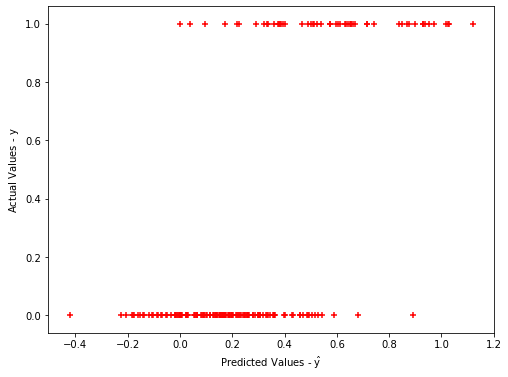

MSE: 0.1160816027850962


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Status   R-squared (uncentered):                   0.589
Model:                            OLS   Adj. R-squared (uncentered):              0.559
Method:                 Least Squares   F-statistic:                              19.66
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                    4.97e-28
Time:                        12:21:40   Log-Likelihood:                         -65.362
No. Observations:                 191   AIC:                                      156.7
Df Residuals:                     178   BIC:                                      199.0
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Population difference            0.1735      0.114      1.518      0.131      -0.052       0.399
Population growth difference    -0.0044      0.018     -0.241      0.810      -0.041       0.032
GDP difference                  -0.1599      0.125     -1.282      0.201      -0.406       0.086
GDP per capita difference        0.3556      0.113      3.159      0.002       0.133       0.578
cpi difference                   0.2803      0.177      1.585      0.115      -0.069       0.629
db difference                   -0.9909      0.268     -3.697      0.000      -1.520      -0.462
pfi difference                  -0.2131      0.159     -1.343      0.181      -0.526       0.100
homicide difference              0.1570      0.105      1.498      0.136      -0.050       0.364
average cpi                      0.0149      0.003      5.064      0.000       0.009       0.021
average db                       0.0028      0.004      0.718      0.474      -0.005       0.011
average pfi                     -0.0008      0.003     -0.308      0.758      -0.006       0.005
average homicide                 0.0068      0.003      2.236      0.027       0.001       0.013
Combined Population          -1.904e-11   8.07e-11     -0.236      0.814   -1.78e-10     1.4e-10
==============================================================================
Omnibus:                       14.269   Durbin-Watson:                   1.660
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.370
Skew:                           0.683   Prob(JB):                     0.000460
Kurtosis:                       3.256   Cond. No.                     4.77e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.77e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
regression('Status',df)

In [29]:
def RFRegressor(y, df):
    X = df.drop([y], 1)
    y = df[y]
    from sklearn.ensemble import RandomForestRegressor
    rf = RandomForestRegressor()
    rf.fit(X, y)
    names = X.dtypes.index
    print("Features sorted by their score:")
    print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
                 reverse=True))
RFRegressor('Status',df)

Features sorted by their score:
[(0.4334, 'average cpi'), (0.1074, 'average homicide'), (0.1023, 'average pfi'), (0.0937, 'GDP per capita difference'), (0.0517, 'average db'), (0.0459, 'Population growth difference'), (0.0346, 'db difference'), (0.0288, 'Population difference'), (0.027, 'Combined Population'), (0.0225, 'homicide difference'), (0.0182, 'cpi difference'), (0.0174, 'pfi difference'), (0.0171, 'GDP difference')]


In [30]:
def decisiontree(df, y):
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import train_test_split
    X = df.drop([y],1)
    y = df[y]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
    clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
    print(clf.score(X_test, y_test))
    return(clf.feature_importances_)
decisiontree(df,'Status')

0.8125


array([0.        , 0.07741376, 0.        , 0.14266635, 0.        ,
       0.04159828, 0.03192204, 0.        , 0.44730723, 0.02394153,
       0.03192204, 0.20322877, 0.        ])

In [31]:
# Load libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
# Create decision tree classifer object
clf = RandomForestClassifier(random_state=0, n_jobs=-1)
X = df.drop('Status',1)
y = df['Status']
# Train model
model = clf.fit(X, y)
pd.DataFrame.from_dict(dict(zip([*X.columns],model.feature_importances_)),orient='index').sort_values(0, ascending = False)

0
average cpi                   0.203977
average pfi                   0.151356
average homicide              0.128732
average db                    0.119171
GDP per capita difference     0.081425
Population growth difference  0.049914
Combined Population           0.045493
homicide difference           0.040115
Population difference         0.039768
db difference                 0.036288
pfi difference                0.036158
GDP difference                0.035932
cpi difference                0.031670

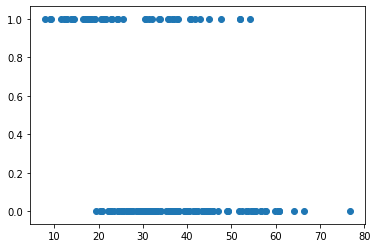

In [32]:
import matplotlib.pyplot as plt
plt.scatter(df['average pfi'],df['Status'])

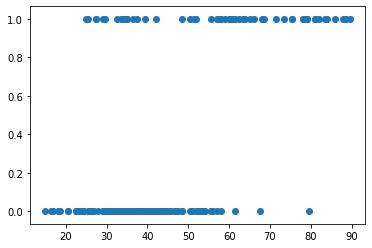

In [33]:
plt.scatter(df['average cpi'],df['Status'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6b962d7d50>,
      dtype=object)

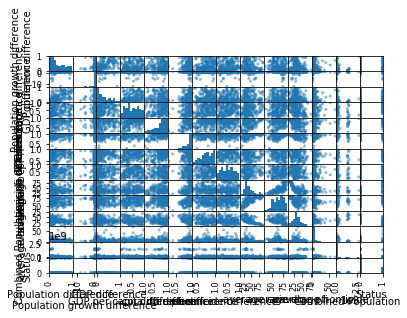

In [34]:
pd.plotting.scatter_matrix(df)

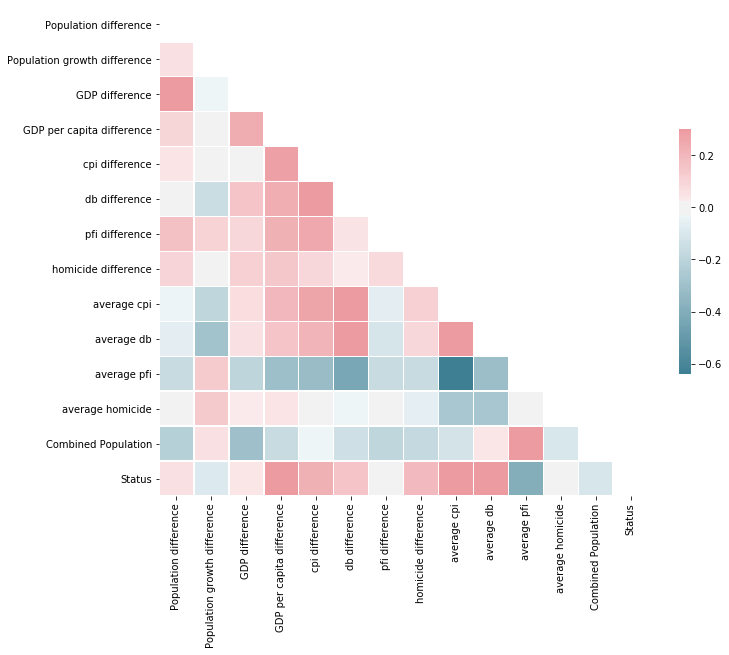

In [35]:
corr = df.corr()


# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

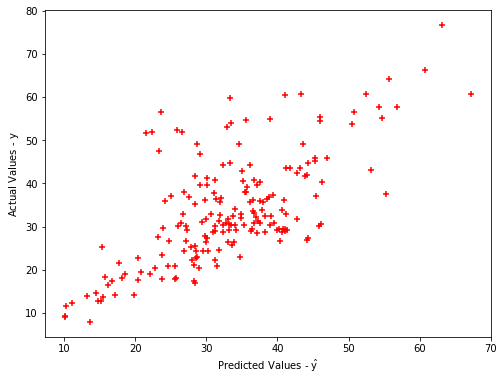

MSE: 86.77004480009339


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            average pfi   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                              190.5
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                    5.43e-97
Time:                        12:21:57   Log-Likelihood:                         -697.26
No. Observations:                 191   AIC:                                      1421.
Df Residuals:                     178   BIC:                                      1463.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Population difference           -1.8077      3.143     -0.575      0.566      -8.010       4.394
Population growth difference     1.0799      0.498      2.170      0.031       0.098       2.062
GDP difference                  -0.1712      3.426     -0.050      0.960      -6.931       6.589
GDP per capita difference       -5.3524      3.138     -1.706      0.090     -11.544       0.839
cpi difference                  -8.7888      4.824     -1.822      0.070     -18.308       0.731
db difference                   19.1086      7.468      2.559      0.011       4.372      33.845
pfi difference                   9.9434      4.296      2.315      0.022       1.467      18.420
homicide difference              2.0988      2.878      0.729      0.467      -3.582       7.779
average cpi                     -0.6703      0.070     -9.635      0.000      -0.808      -0.533
average db                       0.6932      0.094      7.411      0.000       0.509       0.878
average homicide                -0.0164      0.084     -0.194      0.846      -0.183       0.150
Combined Population           1.153e-08   2.03e-09      5.680      0.000    7.52e-09    1.55e-08
Status                          -0.6312      2.049     -0.308      0.758      -4.674       3.412
==============================================================================
Omnibus:                       34.333   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.582
Skew:                           1.030   Prob(JB):                     1.71e-11
Kurtosis:                       4.408   Cond. No.                     4.84e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.84e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
regression('average pfi',df)

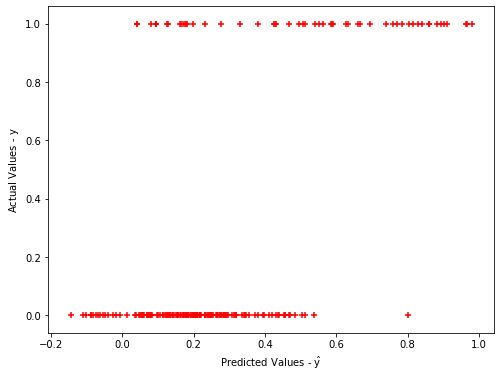

MSE: 0.13782939493667554


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Status   R-squared (uncentered):                   0.512
Model:                            OLS   Adj. R-squared (uncentered):              0.505
Method:                 Least Squares   F-statistic:                              65.88
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                    3.70e-29
Time:                        12:21:57   Log-Likelihood:                         -81.761
No. Observations:                 191   AIC:                                      169.5
Df Residuals:                     188   BIC:                                      179.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
average cpi     0.0135      0.003      4.489      0.000       0.008       0.019
average db     -0.0023      0.003     -0.755      0.451      -0.008       0.004
average pfi    -0.0043      0.002     -1.739      0.084      -0.009       0.001
==============================================================================
Omnibus:                       28.992   Durbin-Watson:                   1.586
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.377
Skew:                           1.064   Prob(JB):                     7.65e-09
Kurtosis:                       3.408   Cond. No.                         15.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
regression('Status',df[['average cpi','average db','average pfi','Status']])

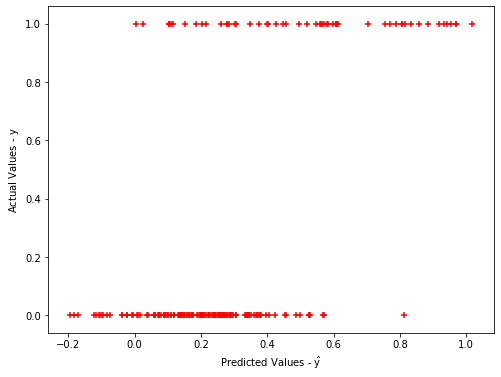

MSE: 0.1332877310803964


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Status   R-squared (uncentered):                   0.529
Model:                            OLS   Adj. R-squared (uncentered):              0.518
Method:                 Least Squares   F-statistic:                              52.41
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                    1.47e-29
Time:                        12:21:58   Log-Likelihood:                         -78.561
No. Observations:                 191   AIC:                                      165.1
Df Residuals:                     187   BIC:                                      178.1
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
average cpi                   0.0138      0.003      4.657      0.000       0.008       0.020
average db                   -0.0050      0.003     -1.562      0.120      -0.011       0.001
average pfi                  -0.0037      0.002     -1.493      0.137      -0.009       0.001
GDP per capita difference     0.2647      0.105      2.524      0.012       0.058       0.472
==============================================================================
Omnibus:                       24.195   Durbin-Watson:                   1.566
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.798
Skew:                           0.960   Prob(JB):                     3.38e-07
Kurtosis:                       3.244   Cond. No.                         338.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
regression('Status',df[['average cpi','average db','average pfi','Status','GDP per capita difference']])

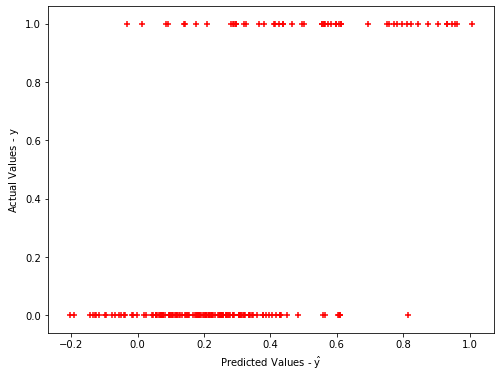

MSE: 0.13194944098724504


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Status   R-squared (uncentered):                   0.533
Model:                            OLS   Adj. R-squared (uncentered):              0.518
Method:                 Least Squares   F-statistic:                              35.23
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                    3.12e-28
Time:                        12:21:58   Log-Likelihood:                         -77.598
No. Observations:                 191   AIC:                                      167.2
Df Residuals:                     185   BIC:                                      186.7
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
average cpi                   0.0145      0.003      4.814      0.000       0.009       0.020
average db                   -0.0046      0.003     -1.351      0.178      -0.011       0.002
average homicide              0.0037      0.003      1.221      0.224      -0.002       0.010
average pfi                  -0.0036      0.002     -1.440      0.152      -0.008       0.001
GDP per capita difference     0.2715      0.111      2.441      0.016       0.052       0.491
cpi difference               -0.1168      0.143     -0.817      0.415      -0.399       0.165
==============================================================================
Omnibus:                       20.972   Durbin-Watson:                   1.611
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.847
Skew:                           0.877   Prob(JB):                     4.02e-06
Kurtosis:                       3.215   Cond. No.                         484.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
regression('Status',df[['average cpi','average db','average homicide','average pfi','Status','GDP per capita difference','cpi difference']])

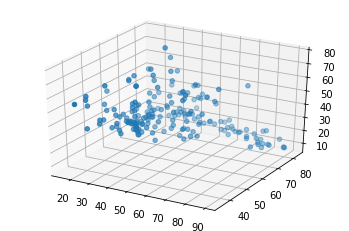

In [40]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df['average cpi'],df['average db'],df['average pfi'], cmap='Greens')

In [41]:
RFRegressor('average pfi',df)

Features sorted by their score:
[(0.4511, 'average cpi'), (0.2008, 'Combined Population'), (0.0552, 'db difference'), (0.0534, 'average homicide'), (0.043, 'pfi difference'), (0.0391, 'average db'), (0.0388, 'cpi difference'), (0.0293, 'GDP per capita difference'), (0.0235, 'homicide difference'), (0.0215, 'Population difference'), (0.0194, 'Population growth difference'), (0.0144, 'GDP difference'), (0.0105, 'Status')]


In [42]:
RFRegressor('average cpi',df)

Features sorted by their score:
[(0.7057, 'average pfi'), (0.1322, 'average db'), (0.047, 'average homicide'), (0.0204, 'Population growth difference'), (0.0178, 'cpi difference'), (0.0173, 'Combined Population'), (0.0125, 'db difference'), (0.0115, 'GDP per capita difference'), (0.0111, 'homicide difference'), (0.0086, 'pfi difference'), (0.0079, 'GDP difference'), (0.006, 'Population difference'), (0.002, 'Status')]


In [43]:
RFRegressor('pfi difference',df)

Features sorted by their score:
[(0.1314, 'average pfi'), (0.1194, 'cpi difference'), (0.1191, 'Population growth difference'), (0.1066, 'GDP per capita difference'), (0.0817, 'homicide difference'), (0.0713, 'Population difference'), (0.071, 'Combined Population'), (0.0703, 'GDP difference'), (0.0632, 'average db'), (0.0603, 'average cpi'), (0.0544, 'db difference'), (0.0481, 'average homicide'), (0.0034, 'Status')]


In [44]:
df1.sort_values('GDP per capita difference', ascending=False)

Country 1                 Country 2            C  2015 cpi_x  \
55       Georgia                Azerbaijan      Georgia        52.0   
115      Ecuador                      Peru      Ecuador        32.0   
201  El Salvador                 Guatemala  El Salvador        39.0   
23       Belgium                   Germany      Belgium        77.0   
176      Ecuador                  Colombia      Ecuador        32.0   
..           ...                       ...          ...         ...   
195     Ethiopia               South Sudan     Ethiopia        33.0   
197       Uganda               South Sudan       Uganda        25.0   
203      Eritrea                     Sudan      Eritrea        18.0   
205  South Sudan  Central African Republic  South Sudan        15.0   
206        Sudan               South Sudan        Sudan        12.0   

     2018 pfi_x  DB 2018_x  DB 2019_x  Region_x      Subregion_x  \
55        27.34      82.80      83.28      Asia     Western Asia   
115       30.56      57.82      57.94  Americas    South America   
201       27.78      65.20      65.41  Americas  Central America   
23        13.16      71.71      73.95    Europe   Western Europe   
176       30.56      57.82      57.94  Americas    South America   
..          ...        ...        ...       ...              ...   
195       50.17      48.15      49.06    Africa   Eastern Africa   
197       36.77      56.41      57.06    Africa   Eastern Africa   
203       84.24      22.94      23.07    Africa   Eastern Africa   
205       46.88      33.30      35.34    Africa   Eastern Africa   
206       71.13      45.09      48.84    Africa  Northern Africa   

     Homicide Rate_x  Homicide County_x  Year_x          Source_x     score_x  \
55              0.99               39.0  2016.0  UNSDC/TSMNEE/CTS  158.396489   
115             5.85              959.0  2016.0           OAS/CTS   60.670157   
201            82.84             5257.0  2016.0       OAS/CTS/RSC   91.828294   
23              1.95              220.0  2015.0           EUR/CTS  432.686170   
176             5.85              959.0  2016.0           OAS/CTS   60.670157   
..               ...                ...     ...               ...         ...   
195             7.56             7552.0  2015.0      WHO Estimate   32.269882   
197            11.52             4473.0  2014.0            CTS/NP   38.795213   
203             8.04              390.0  2015.0      WHO Estimate    4.929487   
205            13.90             1504.0  2012.0                NP   11.307594   
206             5.16             1702.0  2008.0               CTS    8.239561   

    Country Name_x  Population 1  Population growth 1         GDP 1  \
55         Georgia     3719300.0             0.059168  1.437802e+10   
115        Ecuador    16385068.0             1.479917  9.861397e+10   
201    El Salvador     6344722.0             0.509498  2.679747e+10   
23         Belgium    11348159.0             0.653895  4.679557e+11   
176        Ecuador    16385068.0             1.479917  9.861397e+10   
..             ...           ...                  ...           ...   
195       Ethiopia   102403196.0             2.501821  7.237422e+10   
197         Uganda    41487965.0             3.290872  2.407893e+10   
203        Eritrea           NaN                  NaN           NaN   
205    South Sudan    12230730.0             2.891554           NaN   
206          Sudan    39578828.0             2.380440  9.558438e+10   

     GDP per capita 1                Treaty 1                   Country  \
55        3865.785693                    None                Azerbaijan   
115       6018.526868        Andean Community                      Peru   
201       4223.584579       Central America 4                 Guatemala   
23       41236.266589                Schengen                   Germany   
176       6018.526868        Andean Community                  Colombia   
..                ...                     ...                

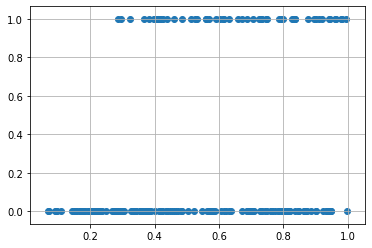

In [45]:
x=df1['GDP per capita difference']
Y=df1['Status']
fig, ax = plt.subplots()
ax.scatter(x, Y)
ax.grid()
plt.show()

In [46]:
df.corr()

Population difference  \
Population difference                      1.000000   
Population growth difference               0.061130   
GDP difference                             0.597309   
GDP per capita difference                  0.096570   
cpi difference                             0.046044   
db difference                              0.002440   
pfi difference                             0.171455   
homicide difference                        0.099199   
average cpi                               -0.031039   
average db                                -0.060826   
average pfi                               -0.162135   
average homicide                          -0.011717   
Combined Population                       -0.224090   
Status                                     0.060815   

                              Population growth difference  GDP difference  \
Population difference                             0.061130        0.597309   
Population growth difference                      1.000000       -0.026612   
GDP difference                                   -0.026612        1.000000   
GDP per capita difference                        -0.018554        0.238460   
cpi difference                                   -0.015237       -0.016734   
db difference                                    -0.152119        0.155043   
pfi difference                                    0.105784        0.092028   
homicide difference                               0.023379        0.115574   
average cpi                                      -0.187536        0.070114   
average db                                       -0.284872        0.056975   
average pfi                                       0.131307       -0.192942   
average homicide                                  0.137688        0.027337   
Combined Population                               0.055924       -0.299704   
Status                                           -0.087696        0.041037   

                              GDP per capita difference  cpi difference  \
Population difference                          0.096570        0.046044   
Population growth difference                  -0.018554       -0.015237   
GDP difference                                 0.238460       -0.016734   
GDP per capita difference                      1.000000        0.281638   
cpi difference                                 0.281638        1.000000   
db difference                                  0.237401        0.542069   
pfi difference                                 0.226310        0.254960   
homicide difference                            0.144116        0.088560   
average cpi                                    0.198452        0.264703   
average db                                     0.155243        0.210833   
average pfi                                   -0.308567       -0.322189   
average homicide                               0.044219        0.003682   
Combined Population                           -0.159222       -0.028429   
Status                                         0.304592        0.224237   

                              db difference  pfi difference  \
Population difference              0.002440        0.171455   
Population growth difference      -0.152119        0.105784   
GDP difference                     0.155043        0.092028   
GDP per capita difference          0.237401        0.226310   
cpi difference                     0.542069        0.254960   
db difference                      1.000000        0.052502   
pfi difference                     0.052502        1.000000   
homicide difference                0.026970        0.082990   
average cpi                        0.408322       -0.063081   
average db                         0.424072       -0.111123   
average pfi                       -0.430823       -0.164801   
average homicide                  -0.027076       -0.016877   
Combined Population               -0.137077       -0.190840   
Status                   

In [47]:
df1.sort_values('GDP per capita difference')

Country 1                 Country 2            C  2015 cpi_x  \
144  Afghanistan                     China  Afghanistan        11.0   
166   Mozambique              South Africa   Mozambique        31.0   
72         Nepal                     China        Nepal        27.0   
91       Algeria                     Niger      Algeria        36.0   
70    Tajikistan                     China   Tajikistan        26.0   
..           ...                       ...          ...         ...   
195     Ethiopia               South Sudan     Ethiopia        33.0   
197       Uganda               South Sudan       Uganda        25.0   
203      Eritrea                     Sudan      Eritrea        18.0   
205  South Sudan  Central African Republic  South Sudan        15.0   
206        Sudan               South Sudan        Sudan        12.0   

     2018 pfi_x  DB 2018_x  DB 2019_x Region_x      Subregion_x  \
144       37.28      37.13      47.77     Asia    Southern Asia   
166       31.12      53.75      55.53   Africa   Eastern Africa   
72        32.05      59.95      59.63     Asia    Southern Asia   
91        43.13      47.59      49.65   Africa  Northern Africa   
70        50.06      57.03      57.11     Asia     Central Asia   
..          ...        ...        ...      ...              ...   
195       50.17      48.15      49.06   Africa   Eastern Africa   
197       36.77      56.41      57.06   Africa   Eastern Africa   
203       84.24      22.94      23.07   Africa   Eastern Africa   
205       46.88      33.30      35.34   Africa   Eastern Africa   
206       71.13      45.09      48.84   Africa  Northern Africa   

     Homicide Rate_x  Homicide County_x  Year_x      Source_x    score_x  \
144             6.35             1948.0  2012.0           NSO  14.095225   
166             3.40              849.0  2011.0       WHO/SDG  55.315874   
72              2.16              627.0  2016.0       NSO/CTS  50.234321   
91              1.36              542.0  2015.0           CTS  41.442152   
70              1.61              126.0  2011.0    TSMNEE/CTS  29.661606   
..               ...                ...     ...           ...        ...   
195             7.56             7552.0  2015.0  WHO Estimate  32.269882   
197            11.52             4473.0  2014.0        CTS/NP  38.795213   
203             8.04              390.0  2015.0  WHO Estimate   4.929487   
205            13.90             1504.0  2012.0            NP  11.307594   
206             5.16             1702.0  2008.0           CTS   8.239561   

    Country Name_x  Population 1  Population growth 1         GDP 1  \
144    Afghanistan    34656032.0             2.689163  1.946902e+10   
166     Mozambique    28829476.0             2.881208  1.101486e+10   
72           Nepal    28982771.0             1.132886  2.113198e+10   
91         Algeria    40606052.0             1.825463  1.590491e+11   
70      Tajikistan     8734951.0             2.155884  6.951657e+09   
..             ...           ...                  ...           ...   
195       Ethiopia   102403196.0             2.501821  7.237422e+10   
197         Uganda    41487965.0             3.290872  2.407893e+10   
203        Eritrea           NaN                  NaN           NaN   
205    South Sudan    12230730.0             2.891554           NaN   
206          Sudan    39578828.0             2.380440  9.558438e+10   

     GDP per capita 1                Treaty 1                   Country  \
144        561.778746                    None                     China   
166        382.069330                    None              South Africa   
72         729.122251    Peace and Friendship                     China   
91        3916.881571                    None                     Niger   
70         795.843864                    None                     China   
..                ...                     ...                       ...   
195        706.757475                    None             

In [48]:
df1[(df1['GDP per capita 2']>30000) | (df1['GDP per capita 1']>30000)].sort_values('GDP per capita difference')

Country 1             Country 2                     C  \
44                 Israel                Jordan                Israel   
122         United States                Mexico         United States   
35              Singapore              Malaysia             Singapore   
64                 Israel               Lebanon                Israel   
126                France                Brazil                France   
29                Austria               Hungary               Austria   
19                 Poland               Germany                Poland   
40                  Qatar          Saudi Arabia                 Qatar   
21             Luxembourg                France            Luxembourg   
9             Switzerland                 Italy           Switzerland   
30                   Oman  United Arab Emirates                  Oman   
18                Belgium            Luxembourg               Belgium   
10                Austria        Czech Republic               Austria   
11             Luxembourg               Germany            Luxembourg   
17                Germany        Czech Republic               Germany   
14                 France           Switzerland                France   
6                 Austria              Slovenia               Austria   
5             Switzerland               Germany           Switzerland   
46   United Arab Emirates          Saudi Arabia  United Arab Emirates   
2                 Austria           Switzerland               Austria   
1                 Finland                Norway               Finland   
16                Ireland        United Kingdom               Ireland   
15                Austria                 Italy               Austria   
20               Slovenia                 Italy              Slovenia   
25                  Spain                France                 Spain   
34                 Canada         United States                Canada   
0                  Sweden                Norway                Sweden   
8                 Denmark               Germany               Denmark   
28                 France                 Italy                France   
3                 Finland                Sweden               Finland   
24                 France               Germany                France   
27                Belgium                France               Belgium   
12                Belgium           Netherlands               Belgium   
4             Netherlands               Germany           Netherlands   
7                 Austria               Germany               Austria   
23                Belgium               Germany               Belgium   

     2015 cpi_x  2018 pfi_x  DB 2018_x  DB 2019_x  Region_x  \
44         61.0       30.26      72.59      73.23      Asia   
122        76.0       23.73      82.76      82.75  Americas   
35         85.0       50.95      84.97      85.24      Asia   
64         61.0       30.26      72.59      73.23      Asia   
126        70.0       21.87      76.30      77.29    Europe   
29         76.0       14.04      78.54      78.57    Europe   
19         62.0       26.59      77.31      76.95    Europe   
40         71.0       40.16      65.25      65.89      Asia   
21         81.0       14.72      69.01      69.01    Europe   
9          86.0       11.27      75.68      75.69    Europe   
30         45.0       40.67      67.21      67.19      Asia   
18         77.0       13.16      71.71      73.95    Europe   
10         76.0       14.04      78.54      78.57    Europe   
11         81.0       14.72      69.01      69.01    Europe   
17         81.0       14.39      78.90      78.90    Europe   
14         70.0       21.87      76.30      77.29    Europe   
6          76.0       14.04      78.54      78.57    Europe   
5          86.0       11.27      75.68      75.69    Europe   
46         70.0       40.86      78.91      81.28      Asia   
2          76.0       14.04      78.54      78.57    E

In [49]:
df1[((df1['GDP per capita 2']>30000) | (df1['GDP per capita 1']>30000))&(df1['Border Status']=='Closed')].sort_values('GDP per capita difference')

Country 1      Country 2              C  2015 cpi_x  2018 pfi_x  \
44          Israel         Jordan         Israel        61.0       30.26   
122  United States         Mexico  United States        76.0       23.73   
35       Singapore       Malaysia      Singapore        85.0       50.95   
64          Israel        Lebanon         Israel        61.0       30.26   
126         France         Brazil         France        70.0       21.87   
40           Qatar   Saudi Arabia          Qatar        71.0       40.16   
34          Canada  United States         Canada        83.0       15.28   

     DB 2018_x  DB 2019_x  Region_x         Subregion_x  Homicide Rate_x  \
44       72.59      73.23      Asia        Western Asia             1.36   
122      82.76      82.75  Americas    Northern America             5.35   
35       84.97      85.24      Asia  South-Eastern Asia             0.32   
64       72.59      73.23      Asia        Western Asia             1.36   
126      76.30      77.29    Europe      Western Europe             1.35   
40       65.25      65.89      Asia        Western Asia             0.38   
34       78.88      79.26  Americas    Northern America             1.68   

     Homicide County_x  Year_x       Source_x     score_x Country Name_x  \
44               110.0  2015.0    NSO/CTS/SDG  147.621613         Israel   
122            17250.0  2016.0   NP/UNSDC/CTS  265.023177  United States   
35                18.0  2016.0   UNSDC/NP/CTS  142.206084      Singapore   
64               110.0  2015.0    NSO/CTS/SDG  147.621613         Israel   
126              875.0  2016.0  UNSDC/EUR/CTS  247.384545         France   
40                 9.0  2014.0       UNSDC/MD  116.488795          Qatar   
34               611.0  2016.0    OAS/CTS/SDG  430.535340         Canada   

     Population 1  Population growth 1         GDP 1  GDP per capita 1  \
44      8547100.0             1.973220  3.177448e+11      37175.742029   
122   323127513.0             0.692801  1.862448e+13      57638.159088   
35      5607283.0             1.297436  2.969757e+11      52962.491569   
64      8547100.0             1.973220  3.177448e+11      37175.742029   
126    66896109.0             0.407491  2.465454e+12      36854.968280   
40      2569804.0             3.495070  1.524519e+11      59324.338773   
34     36286425.0             1.213891  1.529760e+12      42157.927991   

     Treaty 1        Country  2015 cpi_y  2018 pfi_y  DB 2018_y  DB 2019_y  \
44       None         Jordan        53.0       41.71      59.56      60.98   
122      None         Mexico        35.0       48.91      72.27      72.09   
35       None       Malaysia        50.0       47.41      78.03      80.60   
64       None        Lebanon        28.0       31.15      53.97      54.04   
126  Schengen         Brazil        38.0       31.20      57.05      60.01   
40       None   Saudi Arabia        52.0       63.13      61.88      63.50   
34       None  United States        76.0       23.73      82.76      82.75   

     Region_y         Subregion_y  Homicide Rate_y  Homicide County_y  Year_y  \
44       Asia        Western Asia             1.55              145.0  2016.0   
122  Americas     Central America            19.26            24559.0  2016.0   
35       Asia  South-Eastern Asia             2.11              627.0  2013.0   
64       Asia        Western Asia             3.99              235.0  2016.0   
126  Americas       South America            29.53            61283.0  2016.0   
40       Asia        Western Asia             1.50              472.0  2015.0   
34   Americas    Northern America             5.35            17250.0  2016.0   

            Source_y     score_y Country Name_y  Population 2  \
44        CTS/SDG/NP   77.485975         Jordan     9455802.0   
122              NSO   51.587610         Mexico   127540423.0   
35      UNSDC/WHO/NP   85.003164       Malaysia    31187265.0   
64               CTS   48.575281        Lebanon     600

In [50]:
df1[((df1['GDP per capita 2']>30000) & (df1['GDP per capita 1']>30000))&(df1['Border Status']=='Closed')].sort_values('GDP per capita difference')

Country 1      Country 2       C  2015 cpi_x  2018 pfi_x  DB 2018_x  \
34    Canada  United States  Canada        83.0       15.28      78.88   

    DB 2019_x  Region_x       Subregion_x  Homicide Rate_x  Homicide County_x  \
34      79.26  Americas  Northern America             1.68              611.0   

    Year_x     Source_x    score_x Country Name_x  Population 1  \
34  2016.0  OAS/CTS/SDG  430.53534         Canada    36286425.0   

    Population growth 1         GDP 1  GDP per capita 1 Treaty 1  \
34             1.213891  1.529760e+12      42157.927991     None   

          Country  2015 cpi_y  2018 pfi_y  DB 2018_y  DB 2019_y  Region_y  \
34  United States        76.0       23.73      82.76      82.75  Americas   

         Subregion_y  Homicide Rate_y  Homicide County_y  Year_y  \
34  Northern America             5.35            17250.0  2016.0   

        Source_y     score_y Country Name_y  Population 2  \
34  NP/UNSDC/CTS  265.023177  United States   323127513.0   

    Population growth 2         GDP 2  GDP per capita 2 Treaty 2  \
34             0.692801  1.862448e+13      57638.159088     None   

    Population difference  Population growth difference  GDP difference  \
34               0.112298                      0.570728        0.082137   

    GDP per capita difference  cpi difference  db difference  pfi difference  \
34                   0.731424        0.915663       0.957825        0.643911   

    homicide difference  Country Similarity  average cpi  average db  \
34             0.314019            0.707854         79.5      81.005   

    average pfi  average homicide Border Status  Combined Population  \
34       19.505             3.515        Closed          359413938.0   

    viability  Status  
34  93.930724       0

In [51]:
df1[((df1['GDP per capita 2']<30000) & (df1['GDP per capita 1']<30000))&(df1['Border Status']=='Closed')].sort_values('GDP per capita difference')

Country 1     Country 2            C  2015 cpi_x  2018 pfi_x  \
144  Afghanistan         China  Afghanistan        11.0       37.28   
166   Mozambique  South Africa   Mozambique        31.0       31.12   
72         Nepal         China        Nepal        27.0       32.05   
91       Algeria         Niger      Algeria        36.0       43.13   
70    Tajikistan         China   Tajikistan        26.0       50.06   
..           ...           ...          ...         ...         ...   
49       Armenia       Georgia      Armenia        35.0       29.99   
74       Algeria       Tunisia      Algeria        36.0       43.13   
41       Croatia       Hungary      Croatia        51.0       28.94   
104   Kazakhstan         China   Kazakhstan        28.0       54.41   
55       Georgia    Azerbaijan      Georgia        52.0       27.34   

     DB 2018_x  DB 2019_x Region_x      Subregion_x  Homicide Rate_x  \
144      37.13      47.77     Asia    Southern Asia             6.35   
166      53.75      55.53   Africa   Eastern Africa             3.40   
72       59.95      59.63     Asia    Southern Asia             2.16   
91       47.59      49.65   Africa  Northern Africa             1.36   
70       57.03      57.11     Asia     Central Asia             1.61   
..         ...        ...      ...              ...              ...   
49       73.31      75.37     Asia     Western Asia             2.98   
74       47.59      49.65   Africa  Northern Africa             1.36   
41       71.06      71.40   Europe  Southern Europe             1.04   
104      77.16      77.89     Asia     Central Asia             4.81   
55       82.80      83.28     Asia     Western Asia             0.99   

     Homicide County_x  Year_x          Source_x     score_x Country Name_x  \
144             1948.0  2012.0               NSO   14.095225    Afghanistan   
166              849.0  2011.0           WHO/SDG   55.315874     Mozambique   
72               627.0  2016.0           NSO/CTS   50.234321          Nepal   
91               542.0  2015.0               CTS   41.442152        Algeria   
70               126.0  2011.0        TSMNEE/CTS   29.661606     Tajikistan   
..                 ...     ...               ...         ...            ...   
49                87.0  2016.0        TSMNEE/CTS   87.960987        Armenia   
74               542.0  2015.0               CTS   41.442152        Algeria   
41                44.0  2016.0           MOI/CTS  125.825847        Croatia   
104              853.0  2015.0        TSMNEE/CTS   40.083073     Kazakhstan   
55                39.0  2016.0  UNSDC/TSMNEE/CTS  158.396489        Georgia   

     Population 1  Population growth 1         GDP 1  GDP per capita 1  \
144    34656032.0             2.689163  1.946902e+10        561.778746   
166    28829476.0             2.881208  1.101486e+10        382.069330   
72     28982771.0             1.132886  2.113198e+10        729.122251   
91     40606052.0             1.825463  1.590491e+11       3916.881571   
70      8734951.0             2.155884  6.951657e+09        795.843864   
..            ...                  ...           ...               ...   
49      2924816.0             0.269302  1.057230e+10       3614.688357   
74     40606052.0             1.825463  1.590491e+11       3916.881571   
41      4170600.0            -0.788234  5.071496e+10      12160.110629   
104    17797032.0             1.431251  1.372783e+11       7713.551343   
55      3719300.0             0.059168  1.437802e+10       3865.785693   

                 Treaty 1       Country  2015 cpi_y  2018 pfi_y  DB 2018_y  \
144                  None         China        37.0       78.29      65.00   
166                  None  South Africa        44.0       20.39      64.66   
72   Peace and Friendship         China        37.0       78.29      65.00   
91                   None         Niger        34.0       27.40      52.48   
70                   None         China        37.0       78.

In [52]:
df1[((df1['GDP per capita 2']>30000) | (df1['GDP per capita 1']>30000))&(df1['Border Status']=='Open')].sort_values('GDP per capita difference')

Country 1             Country 2                     C  \
29               Austria               Hungary               Austria   
19                Poland               Germany                Poland   
21            Luxembourg                France            Luxembourg   
9            Switzerland                 Italy           Switzerland   
30                  Oman  United Arab Emirates                  Oman   
18               Belgium            Luxembourg               Belgium   
10               Austria        Czech Republic               Austria   
11            Luxembourg               Germany            Luxembourg   
17               Germany        Czech Republic               Germany   
14                France           Switzerland                France   
6                Austria              Slovenia               Austria   
5            Switzerland               Germany           Switzerland   
46  United Arab Emirates          Saudi Arabia  United Arab Emirates   
2                Austria           Switzerland               Austria   
1                Finland                Norway               Finland   
16               Ireland        United Kingdom               Ireland   
15               Austria                 Italy               Austria   
20              Slovenia                 Italy              Slovenia   
25                 Spain                France                 Spain   
0                 Sweden                Norway                Sweden   
8                Denmark               Germany               Denmark   
28                France                 Italy                France   
3                Finland                Sweden               Finland   
24                France               Germany                France   
27               Belgium                France               Belgium   
12               Belgium           Netherlands               Belgium   
4            Netherlands               Germany           Netherlands   
7                Austria               Germany               Austria   
23               Belgium               Germany               Belgium   

    2015 cpi_x  2018 pfi_x  DB 2018_x  DB 2019_x Region_x      Subregion_x  \
29        76.0       14.04      78.54      78.57   Europe   Western Europe   
19        62.0       26.59      77.31      76.95   Europe   Eastern Europe   
21        81.0       14.72      69.01      69.01   Europe   Western Europe   
9         86.0       11.27      75.68      75.69   Europe   Western Europe   
30        45.0       40.67      67.21      67.19     Asia     Western Asia   
18        77.0       13.16      71.71      73.95   Europe   Western Europe   
10        76.0       14.04      78.54      78.57   Europe   Western Europe   
11        81.0       14.72      69.01      69.01   Europe   Western Europe   
17        81.0       14.39      78.90      78.90   Europe   Western Europe   
14        70.0       21.87      76.30      77.29   Europe   Western Europe   
6         76.0       14.04      78.54      78.57   Europe   Western Europe   
5         86.0       11.27      75.68      75.69   Europe   Western Europe   
46        70.0       40.86      78.91      81.28     Asia     Western Asia   
2         76.0       14.04      78.54      78.57   Europe   Western Europe   
1         90.0       10.26      80.30      80.35   Europe  Northern Europe   
16        75.0       14.59      79.42      78.91   Europe  Northern Europe   
15        76.0       14.04      78.54      78.57   Europe   Western Europe   
20        60.0       21.69      75.59      75.61   Europe  Southern Europe   
25        58.0       20.51      77.61      77.68   Europe  Southern Europe   
0         89.0        8.31      81.27      81.27   Europe  Northern Europe   
8         91.0       13.99      84.05      84.64   Europe  Northern Europe   
28        70.0       21.87      76.30      77.29   Europe   Western Europe   
3         90.0       10.26      80.30      80.35   Europe  N

In [53]:
df1[((df1['GDP per capita 2']<30000) & (df1['GDP per capita 1']<30000))&(df1['Border Status']=='Open')].sort_values('GDP per capita difference')

Country 1       Country 2             C  2015 cpi_x  2018 pfi_x  \
168       Burundi        Tanzania       Burundi        21.0       55.26   
158        Uganda           Kenya        Uganda        25.0       36.77   
118       Burundi          Rwanda       Burundi        21.0       55.26   
88          Nepal           India         Nepal        27.0       32.05   
123          Peru         Bolivia          Peru        36.0       30.27   
207   El Salvador        Honduras   El Salvador        39.0       27.78   
204      Honduras       Guatemala      Honduras        31.0       45.23   
31       Slovenia         Hungary      Slovenia        60.0       21.69   
124         Kenya        Tanzania         Kenya        25.0       30.82   
57         Bhutan           India        Bhutan        65.0       30.73   
163        Uganda        Tanzania        Uganda        25.0       36.77   
22         Poland  Czech Republic        Poland        62.0       26.59   
61   Saudi Arabia          Kuwait  Saudi Arabia        52.0       63.13   
13       Portugal           Spain      Portugal        63.0       14.17   
50           Oman    Saudi Arabia          Oman        45.0       40.67   
37        Estonia          Latvia       Estonia        70.0       14.08   
102      Tanzania          Rwanda      Tanzania        30.0       30.65   
127        Uganda          Rwanda        Uganda        25.0       36.77   
47         Poland       Lithuania        Poland        62.0       26.59   
200      Honduras       Nicaragua      Honduras        31.0       45.23   
53      Lithuania          Latvia     Lithuania        61.0       22.20   
171      Colombia            Peru      Colombia        37.0       41.03   
176       Ecuador        Colombia       Ecuador        32.0       30.56   
201   El Salvador       Guatemala   El Salvador        39.0       27.78   
115       Ecuador            Peru       Ecuador        32.0       30.56   

     DB 2018_x  DB 2019_x  Region_x      Subregion_x  Homicide Rate_x  \
168      46.68      47.41    Africa   Eastern Africa             6.02   
158      56.41      57.06    Africa   Eastern Africa            11.52   
118      46.68      47.41    Africa   Eastern Africa             6.02   
88       59.95      59.63      Asia    Southern Asia             2.16   
123      68.27      68.83  Americas    South America             7.67   
207      65.20      65.41  Americas  Central America            82.84   
204      58.13      58.22  Americas  Central America            56.52   
31       75.59      75.61    Europe  Southern Europe             0.48   
124      65.06      70.31    Africa   Eastern Africa             4.87   
57       65.88      66.08      Asia    Southern Asia             1.13   
163      56.41      57.06    Africa   Eastern Africa            11.52   
22       77.31      76.95    Europe   Eastern Europe             0.67   
61       61.88      63.50      Asia     Western Asia             1.50   
13       76.62      76.55    Europe  Southern Europe             0.64   
50       67.21      67.19      Asia     Western Asia             0.66   
37       80.49      80.50    Europe  Northern Europe             3.19   
102      53.29      53.63    Africa   Eastern Africa             6.95   
127      56.41      57.06    Africa   Eastern Africa            11.52   
47       77.31      76.95    Europe   Eastern Europe             0.67   
200      58.13      58.22  Americas  Central America            56.52   
53       80.54      80.83    Europe  Northern Europe             5.25   
171      69.04      69.24  Americas    South America            25.50   
176      57.82      57.94  Americas    South America             5.85   
201      65.20      65.41  Americas  Central America            82.84   
115      57.82      57.94  Americas    South America             5.85   

     Homicide County_x  Year_x       Source_x     score_x Country Name_x  \
168              635.0  2016.0        CTS/SDG   18.016830        Burundi   
158   

In [54]:
df1[['Country 1','Country 2']]

Country 1                 Country 2
0         Sweden                    Norway
1        Finland                    Norway
2        Austria               Switzerland
3        Finland                    Sweden
4    Netherlands                   Germany
..           ...                       ...
203      Eritrea                     Sudan
204     Honduras                 Guatemala
205  South Sudan  Central African Republic
206        Sudan               South Sudan
207  El Salvador                  Honduras

[208 rows x 2 columns]